In [1]:
import tensorflow
import numpy
import matplotlib

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.6.0
1.21.4
3.4.3


## 데이터 로드 

In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [11]:
import os
data_dir = os.getenv('HOME')+'/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # [[YOUR CODE]]
    cleaned_corpus = []
    for i, j in zip(kor, eng):
        cleaned_corpus.append(i + "\t" + j)

    cleaned_corpus = list(set(cleaned_corpus))
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [12]:
cleaned_corpus[0]

"중국이 604억달러의 비용이 소요되는 아마도 세계 에서 가장 값비싼 계획 중의 하나이며, 중국 역사상 가장 규모가 큰 수로 변경 계획을 밝혔다.\tChina has unveiled plans for the largest water-diversion in its history and possibly one of the world's most expensive at $60.4 billion."

### 데이터 정제 

In [13]:
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣ㅏ-ㅣ?.!,]+", " ", sentence)
    
    sentence = sentence.strip()

    return sentence

###  
한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

In [15]:
import sentencepiece as spm

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # sentencepiece train을 위해 해당 corpus를 별도 파일로 만듬.
    temp_file = f"{lang}_corpus.txt"
    with open(temp_file, "w") as f:
        for sen in corpus:
            f.write(sen)
            f.write("\n")
    
    #  sentencepiece train
    model_name = f"{lang}_spm"
    spm.SentencePieceTrainer.train(input=temp_file, 
                                   model_prefix=model_name, 
                                   vocab_size=vocab_size, 
                                   pad_id=pad_id, 
                                   bos_id=bos_id, 
                                   eos_id=eos_id, 
                                   unk_id=unk_id)
    
    #  sentencepiece load
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(model_name + ".model")
    
    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_wh

True

In [18]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해
import tensorflow as tf

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    # [[YOUR CODE]]
    encoded_kor = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    encoded_eng = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    if len(encoded_kor) <= 50 and len(encoded_eng) <= 50:
        src_corpus.append(encoded_kor)
        tgt_corpus.append(encoded_eng)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [21]:
print(len(enc_train))
print(len(dec_train)) 

72143
72143


In [22]:
enc_train.shape

(72143, 50)

In [23]:
dec_train.shape

(72143, 50)

In [24]:
from tensorflow import keras
import numpy as np

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        # scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, [0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        x = tf.transpose(x, [0, 2, 1, 3])
        combined_x = tf.reshape(x, (batch_size, -1, self.d_model))
        return combined_x


    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
        -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_split = self.split_heads(WQ)
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(WQ_split, WK_split, WV_split, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [26]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn
    

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.dec_enc_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_enc_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn

In [28]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [29]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out 
        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns
        
 

In [30]:
transformer = Transformer(
    n_layers=2,
    d_model=128,
    n_heads=8,
    d_ff=512,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=50,
    dropout=0.2,
)

In [31]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

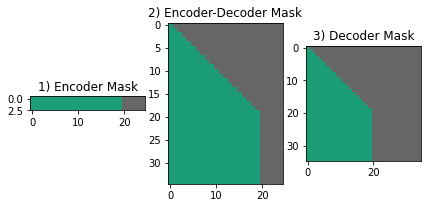

In [32]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [33]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)


In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [35]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [36]:
# Attention 시각화 함수
import matplotlib.pyplot as plt
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [37]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [38]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [39]:
from tqdm import tqdm_notebook 
import random

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_33/99984386.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the government is not be be be be be be .
Input: 시민들은 도시 속에 산다.
Predicted translation: the government is not be be be be be be .
Input: 커피는 필요 없다.
Predicted translation: the government said the new york .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the korea s government said the u . s . s . s .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s campaign is a new democratic presidential campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the number of the same people have been a year old man .
Input: 커피는 필요 없다.
Predicted translation: the year old is not a lot .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the people were killed in the dead .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president , obama said .
Input: 시민들은 도시 속에 산다.
Predicted translation: the red cross is a day .
Input: 커피는 필요 없다.
Predicted translation: http article . joins .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president , and obama s  ⁇ 
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a hugely place .
Input: 커피는 필요 없다.
Predicted translation: if you can t be able to do .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president , , , , , , , , , , , , , , , , , , , , , , , , , , with the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the victims are more than a dozens of people .
Input: 커피는 필요 없다.
Predicted translation: you don t want to do .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the victims are also in the city .
Input: 커피는 필요 없다.
Predicted translation: it doesn t want to do .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: it is the most of the city .
Input: 커피는 필요 없다.
Predicted translation: it s not enough to eat .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama sing a greater .
Input: 시민들은 도시 속에 산다.
Predicted translation: there are some people in the city .
Input: 커피는 필요 없다.
Predicted translation: it doesn t want to produce any food .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the deadliest attack .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there is no one of the city s cities .
Input: 커피는 필요 없다.
Predicted translation: it doesn t want to do it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , the official said .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: one of the city s cities is one of the city .
Input: 커피는 필요 없다.
Predicted translation: it s not enough food .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the country .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama has a greater tour .
Input: 시민들은 도시 속에 산다.
Predicted translation: there is a few miles in the city .
Input: 커피는 필요 없다.
Predicted translation: it s not a perfecter toilet .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there is a mountainous area .
Input: 커피는 필요 없다.
Predicted translation: it s not enough .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the deadliest .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a nice tour of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there are few people in the city .
Input: 커피는 필요 없다.
Predicted translation: it doesn t don t know anything .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a my death toll from the deadliest .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there is a few miles away .
Input: 커피는 필요 없다.
Predicted translation: it never never let your farm .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the deadliest .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there are few people in the city .
Input: 커피는 필요 없다.
Predicted translation: it doesn t do it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a my death toll was killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a greater .
Input: 시민들은 도시 속에 산다.
Predicted translation: there s a little more place in the city .
Input: 커피는 필요 없다.
Predicted translation: it doesn t produce food .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from seven , according to a u . s . official .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there are few people in the city .
Input: 커피는 필요 없다.
Predicted translation: it s not just for food .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . a . m . et .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there are some places in the city .
Input: 커피는 필요 없다.
Predicted translation: it doesn t give you food .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from sunday said the deaths were among , according to the associated press .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re in the city , where the city is in place .
Input: 커피는 필요 없다.
Predicted translation: it doesn t give any food .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a my death toll was killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there are few people seen in their city .
Input: 커피는 필요 없다.
Predicted translation: it doesn t don t don t do anything .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . a . m . et .


Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


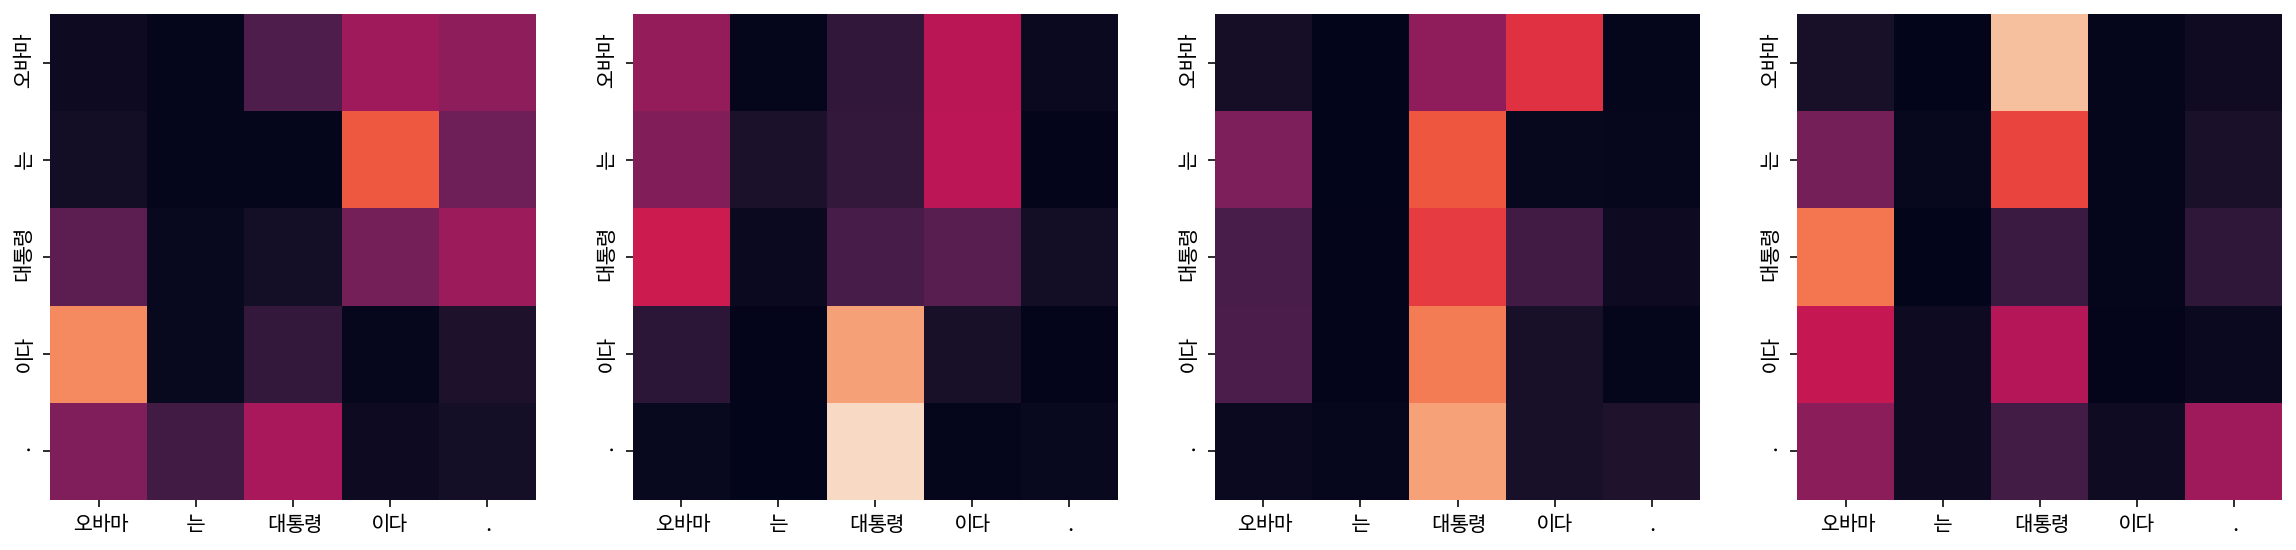

Encoder Layer 2


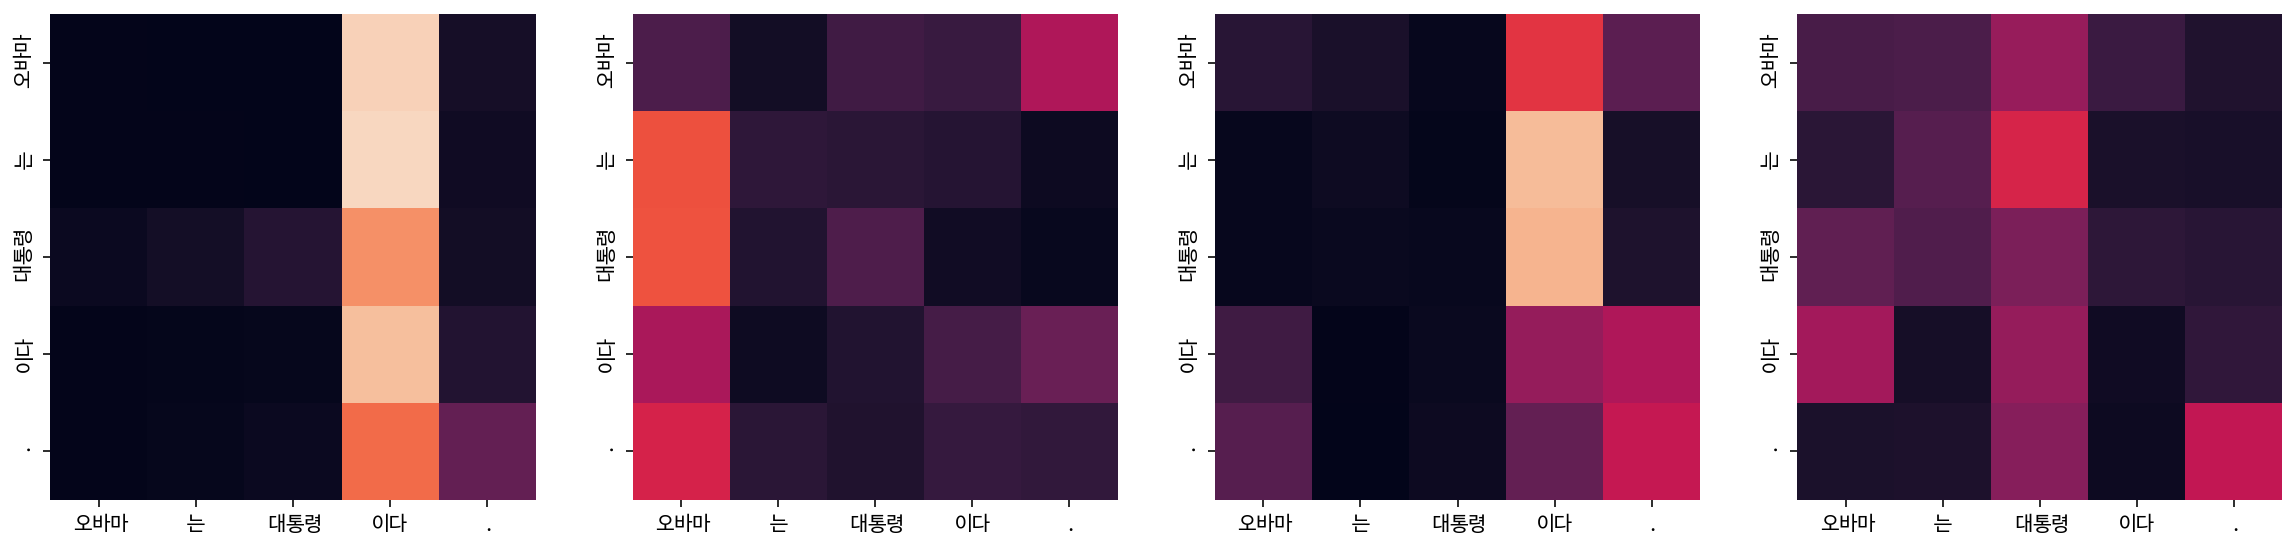

Decoder Self Layer 1


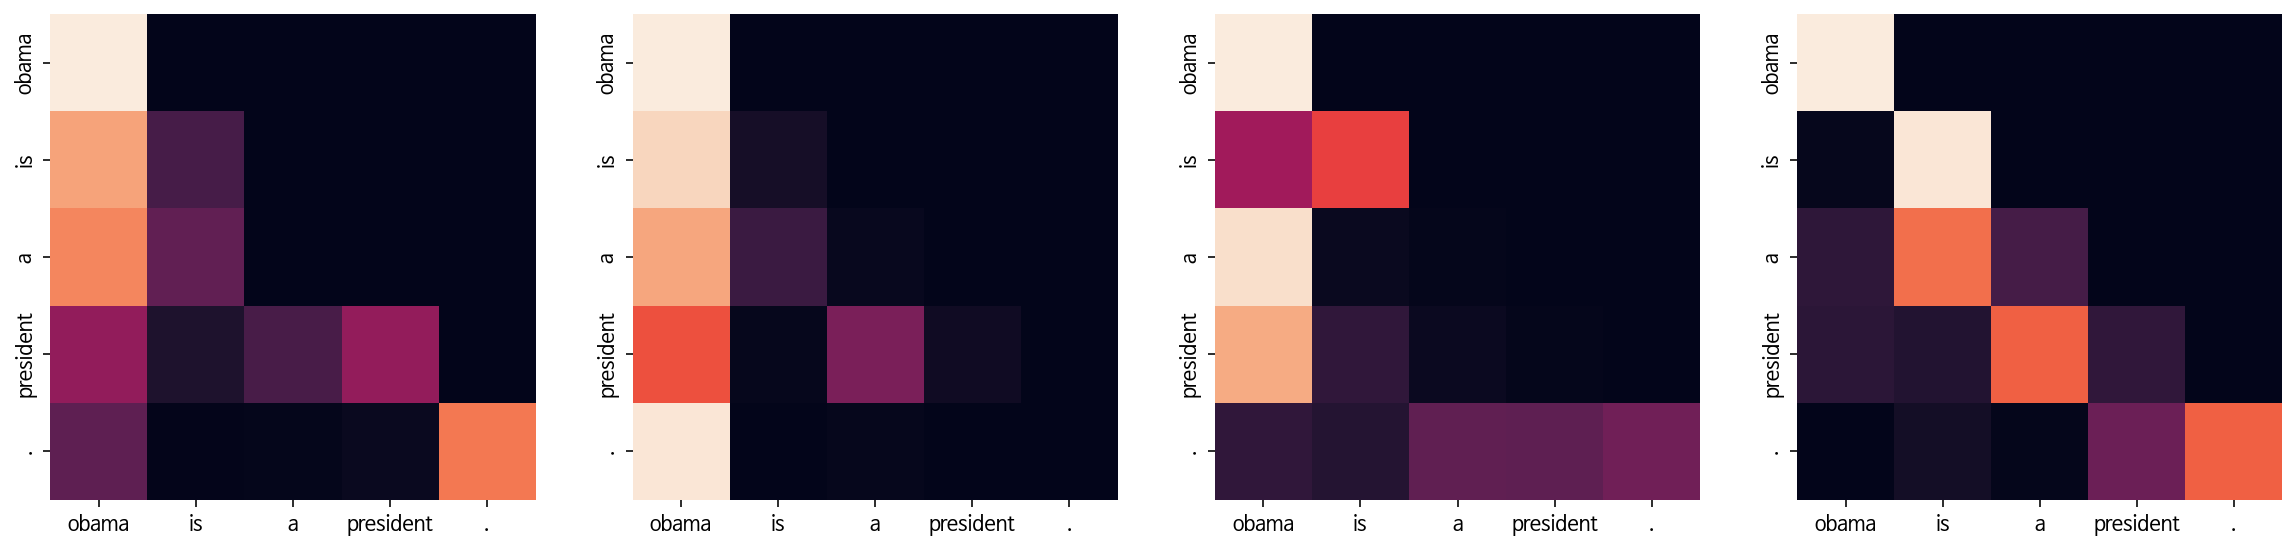

Decoder Src Layer 1


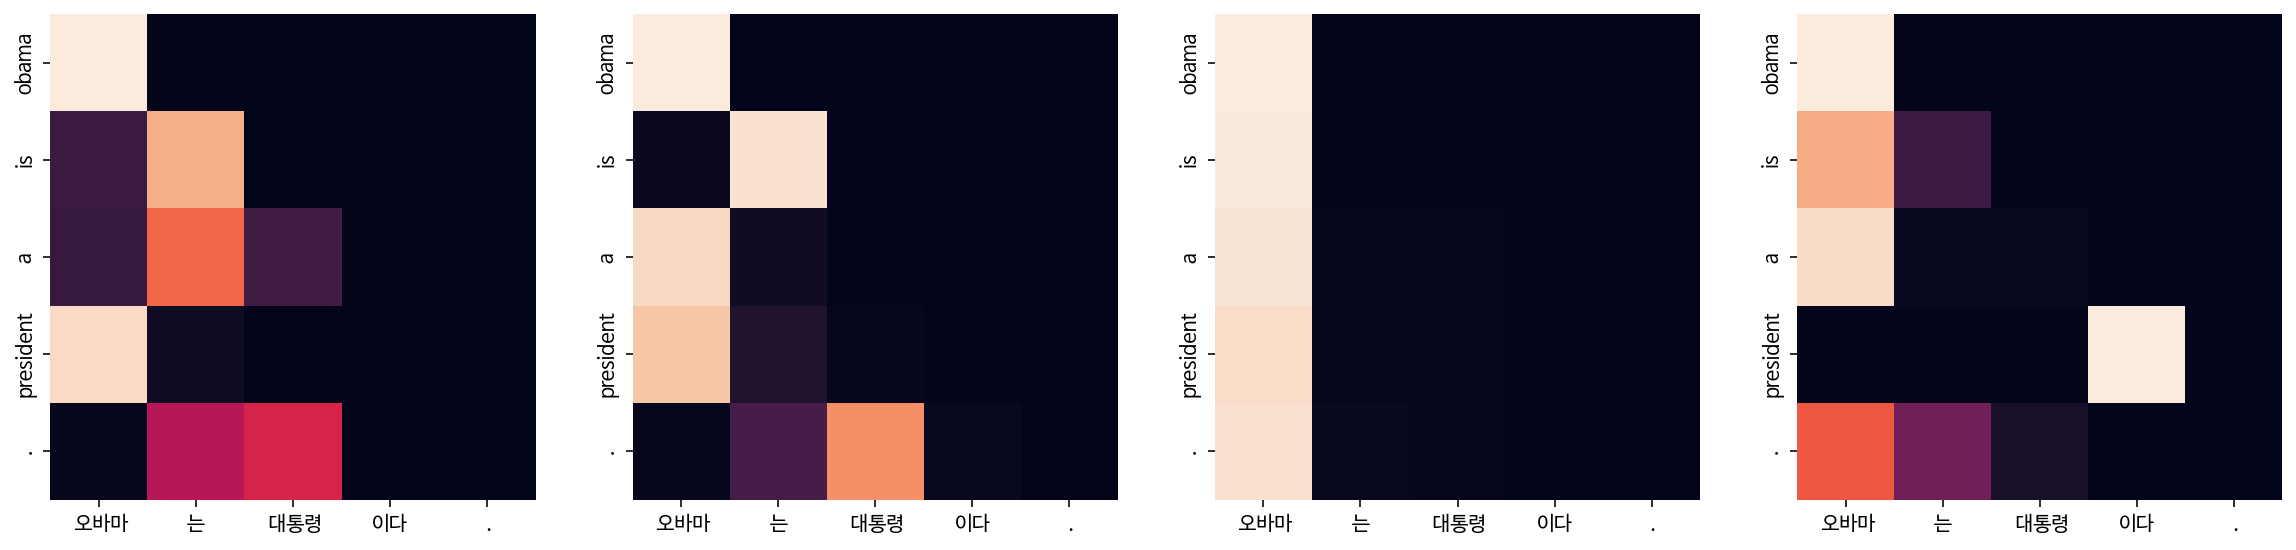

Decoder Self Layer 2


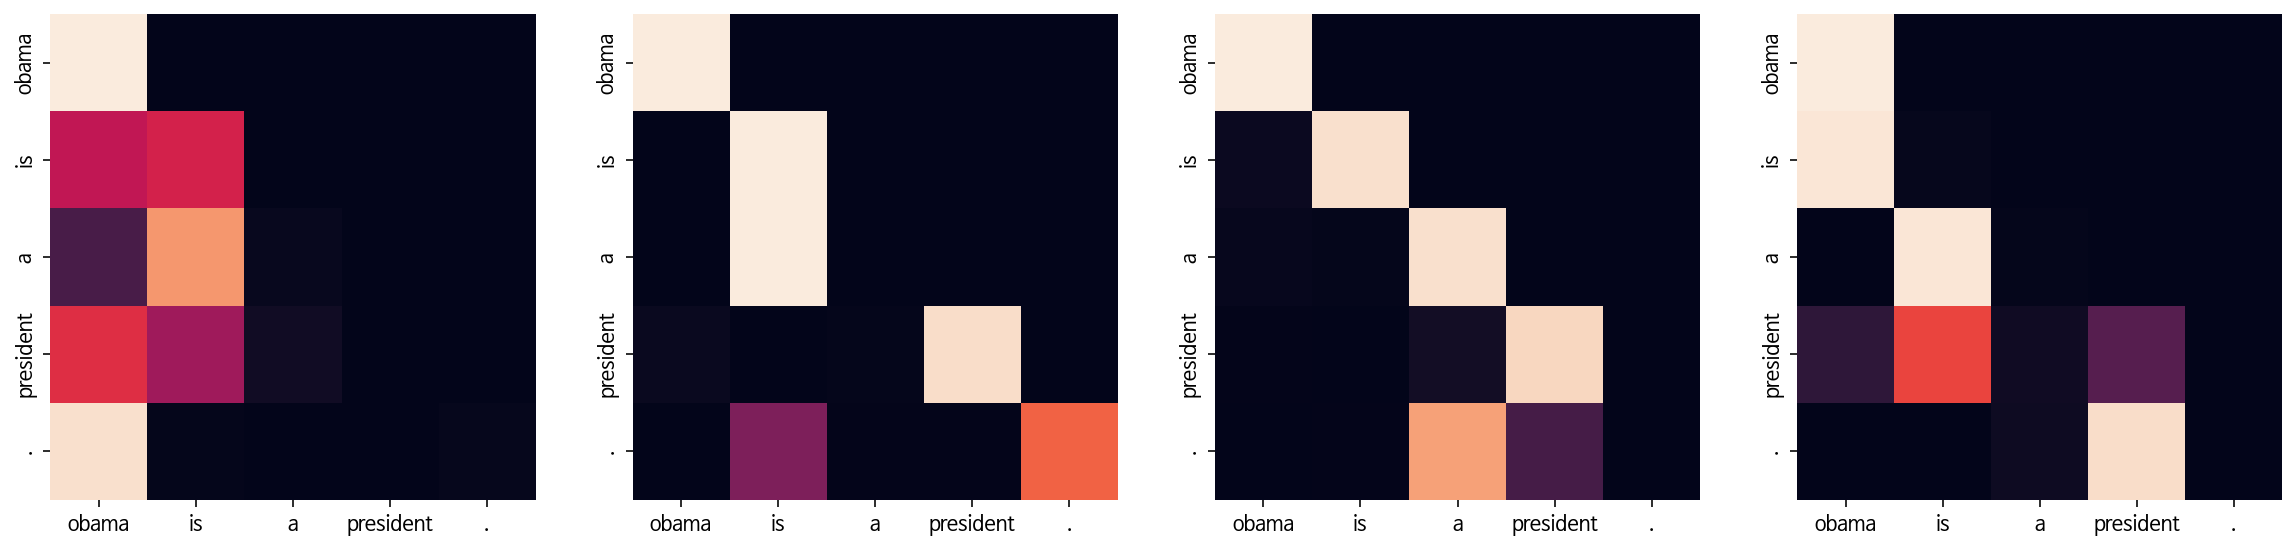

Decoder Src Layer 2


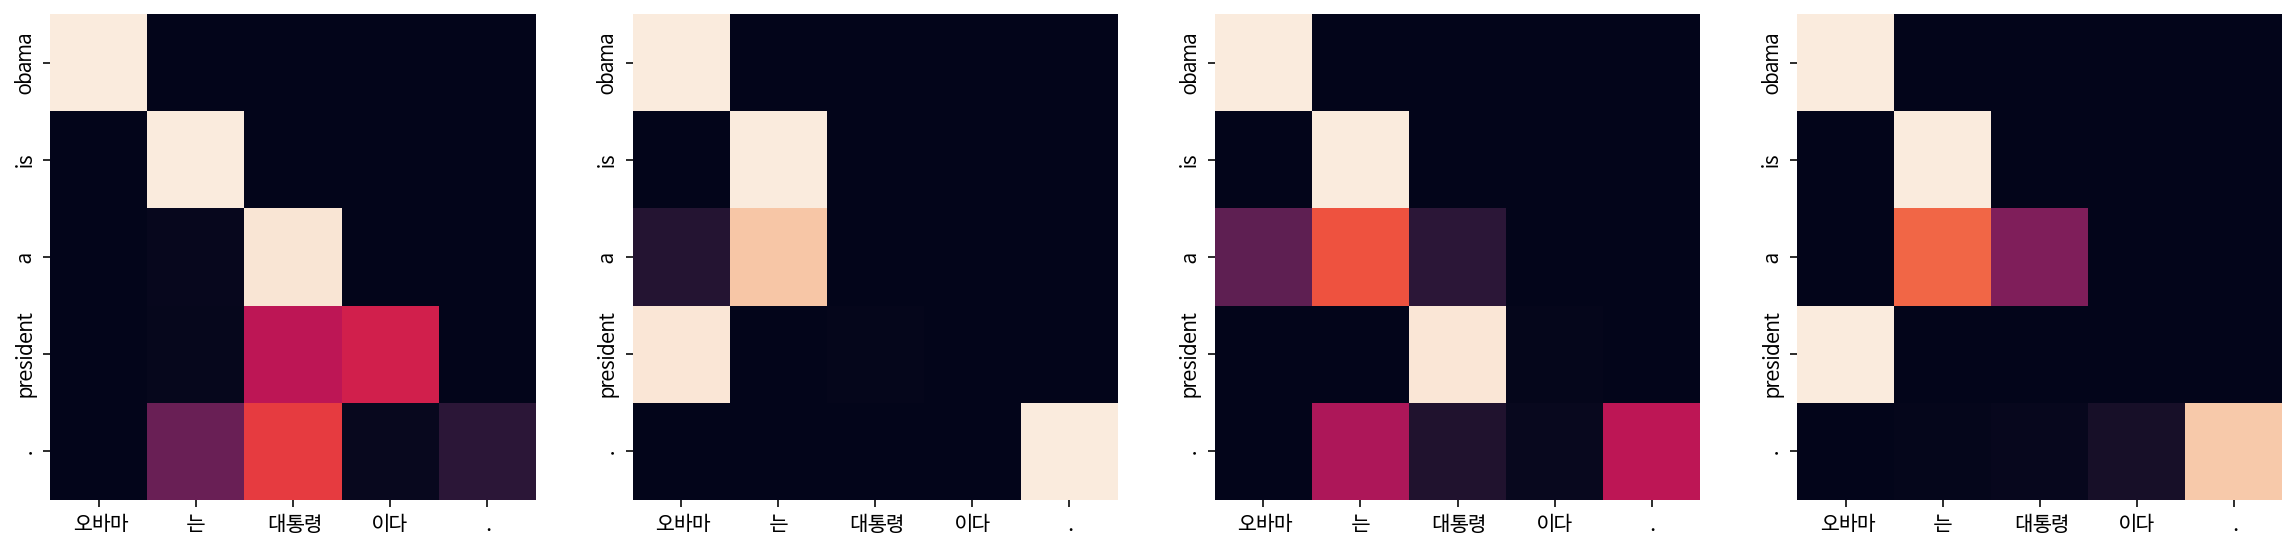

Input: 시민들은 도시 속에 산다.
Predicted translation: there are few people seen in their city .
Encoder Layer 1


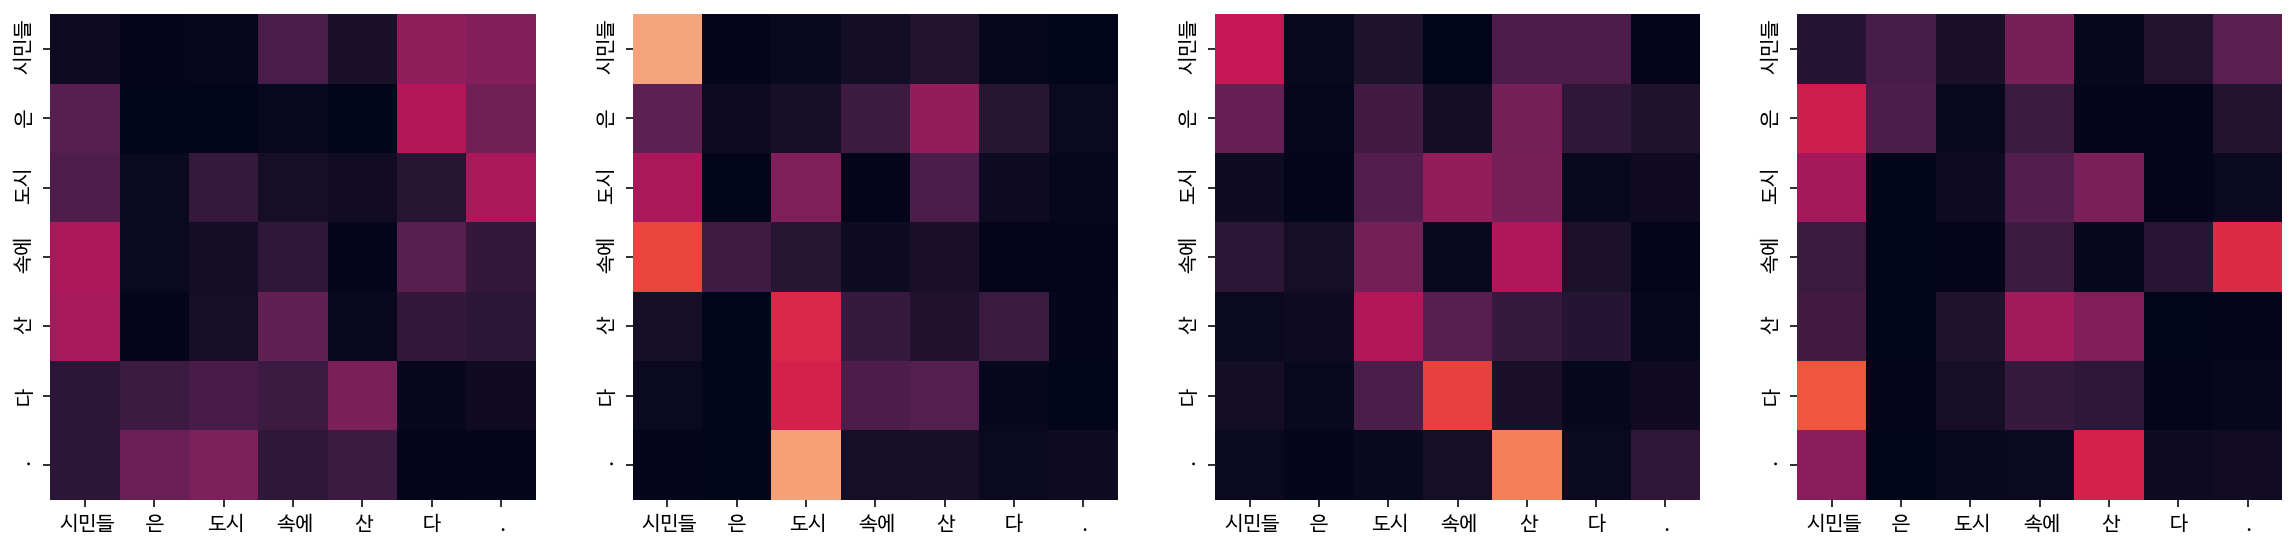

Encoder Layer 2


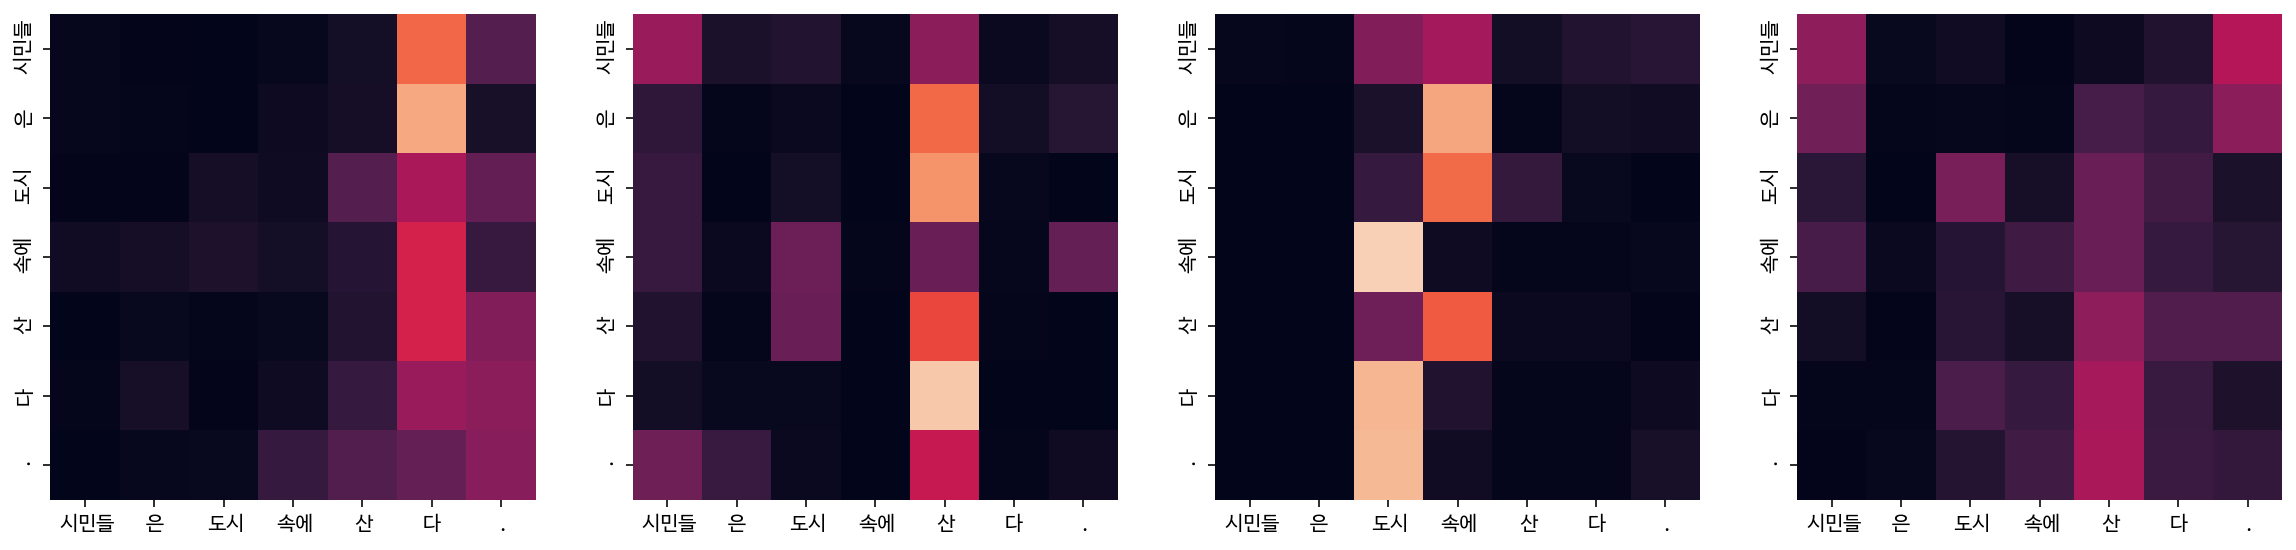

Decoder Self Layer 1


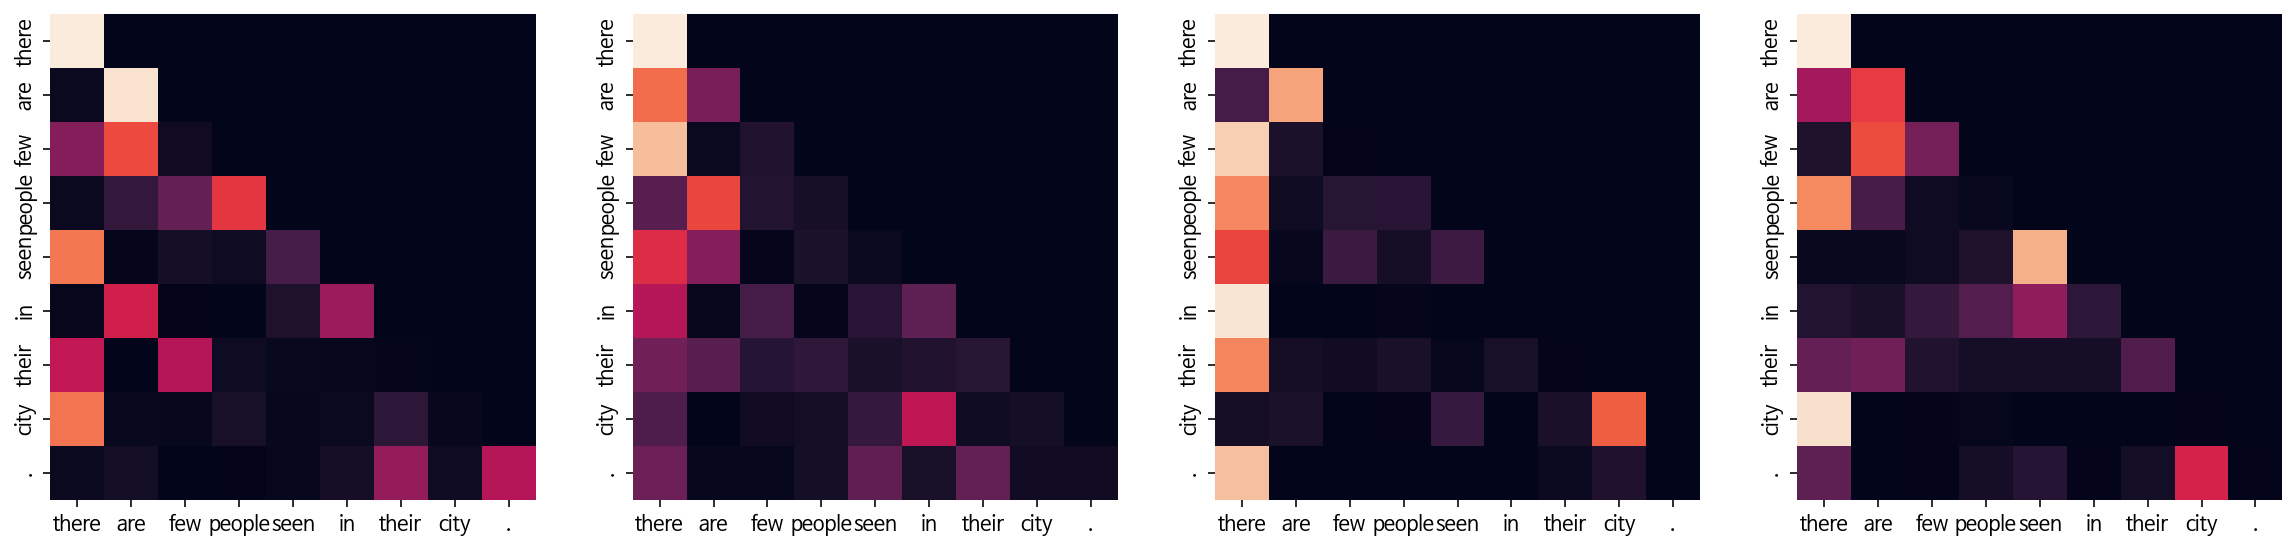

Decoder Src Layer 1


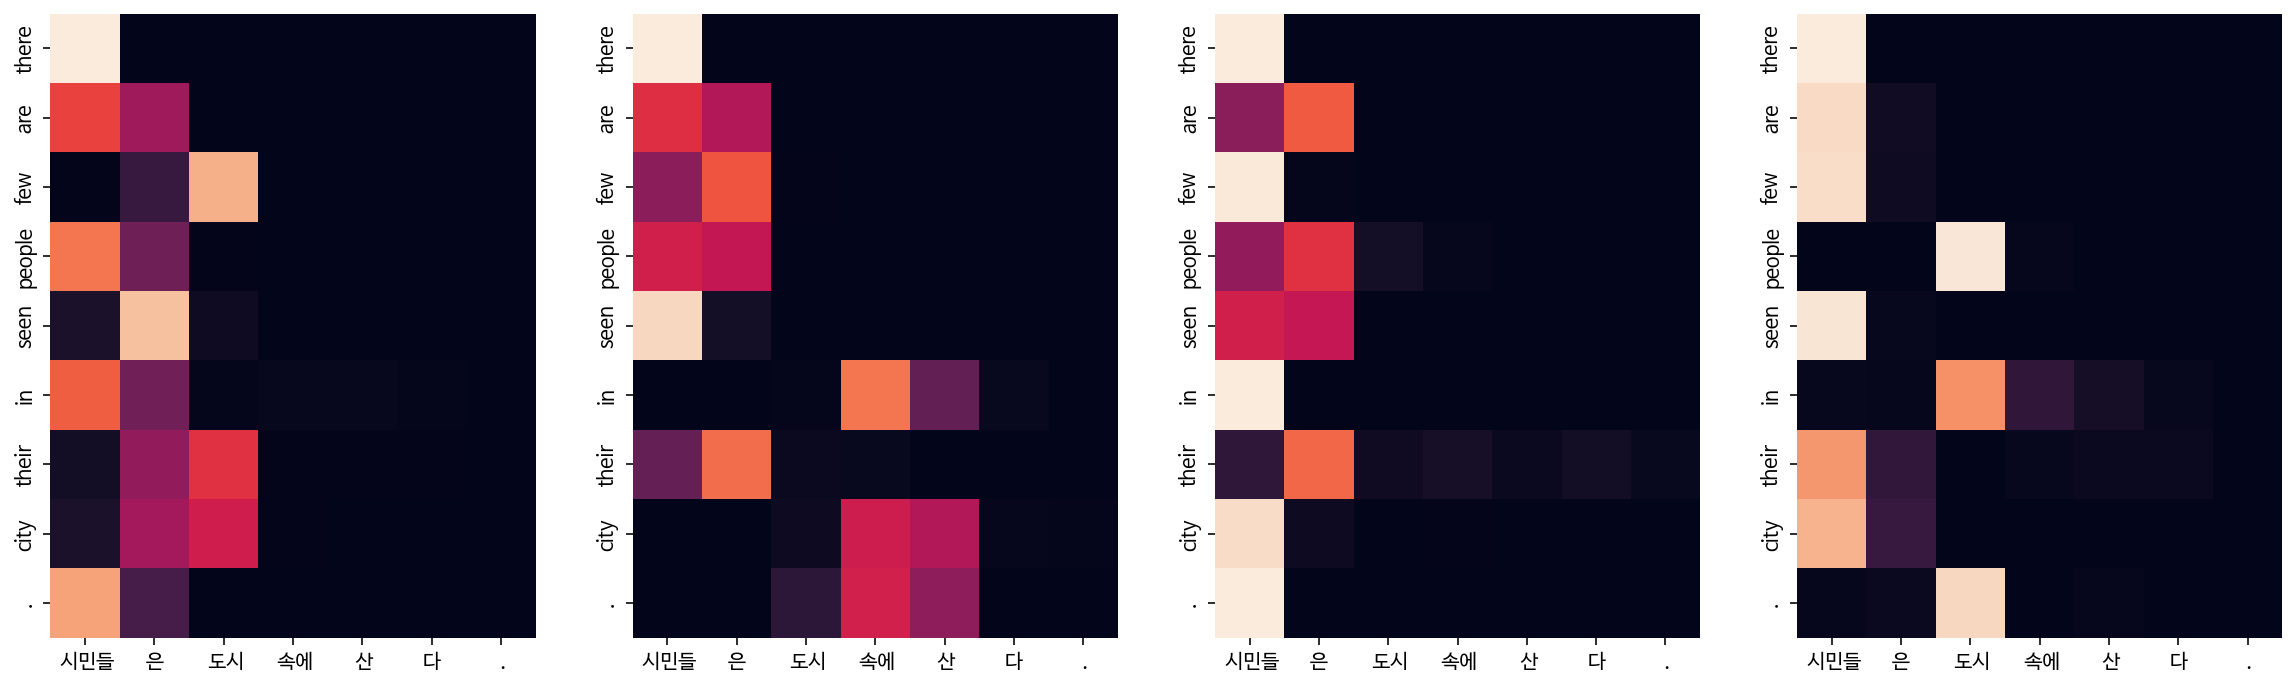

Decoder Self Layer 2


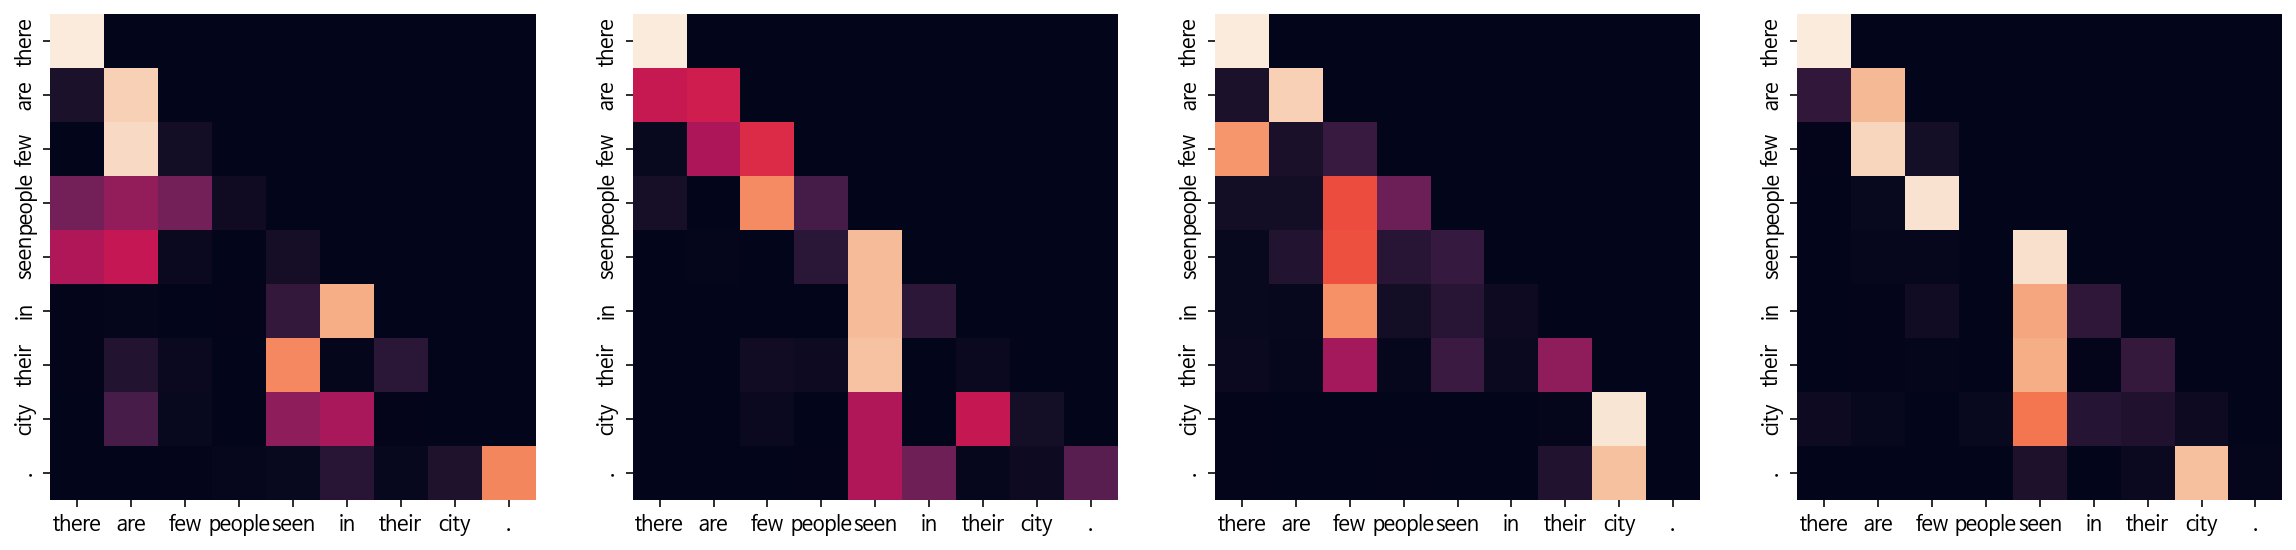

Decoder Src Layer 2


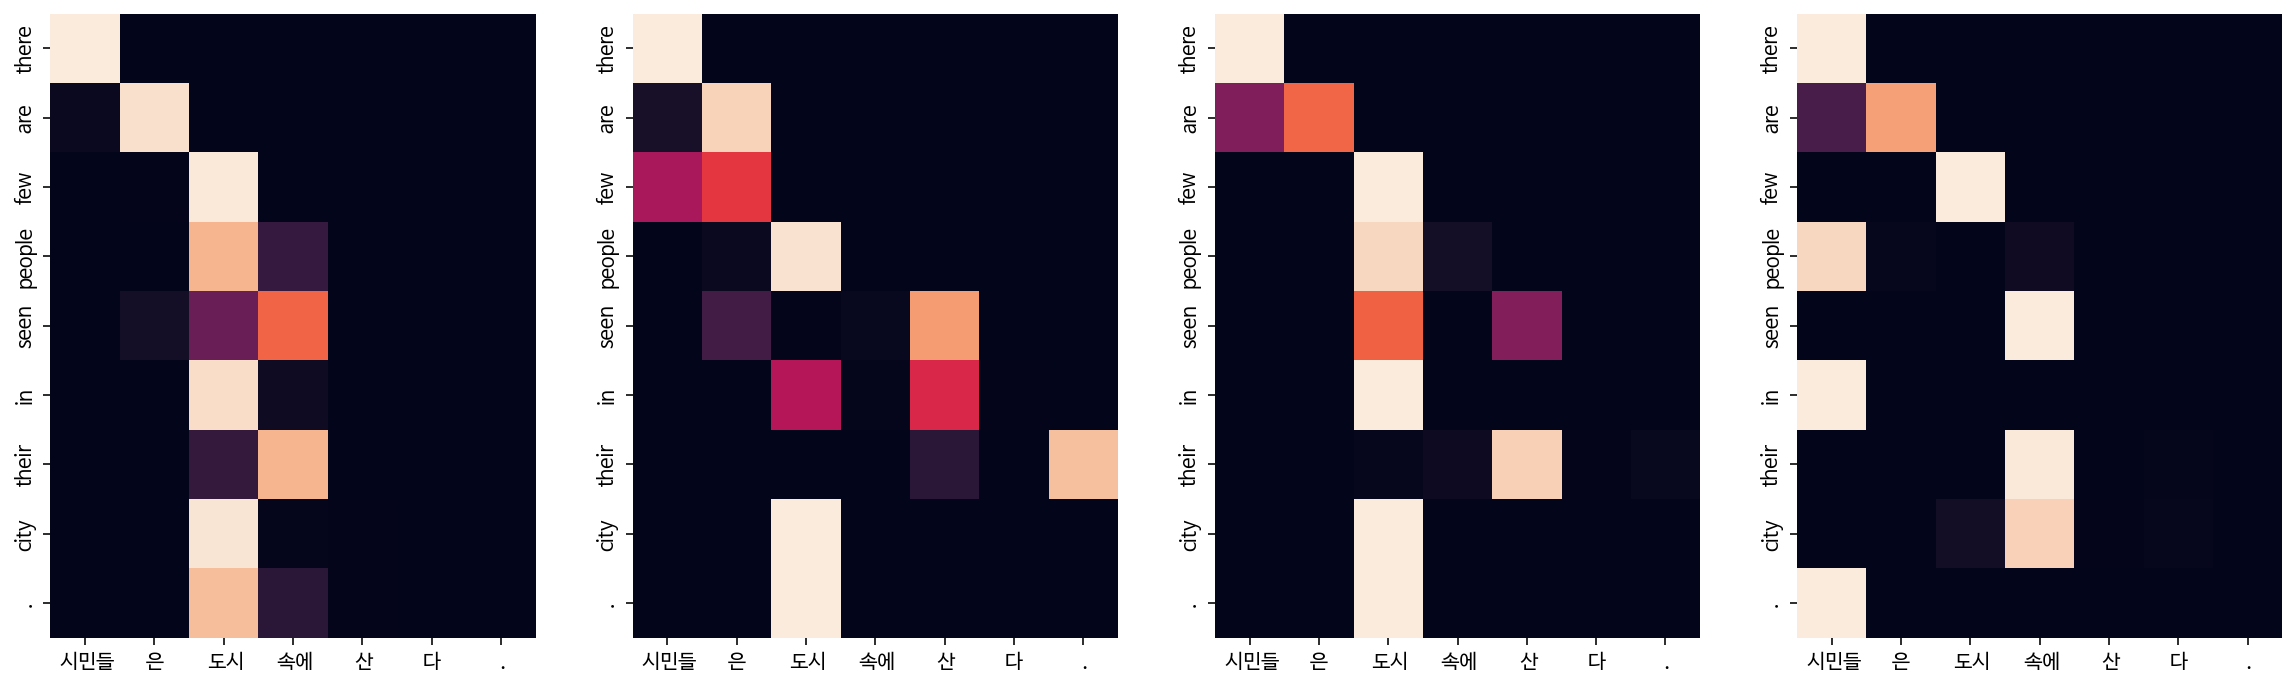

Input: 커피는 필요 없다.
Predicted translation: it doesn t don t don t do anything .
Encoder Layer 1


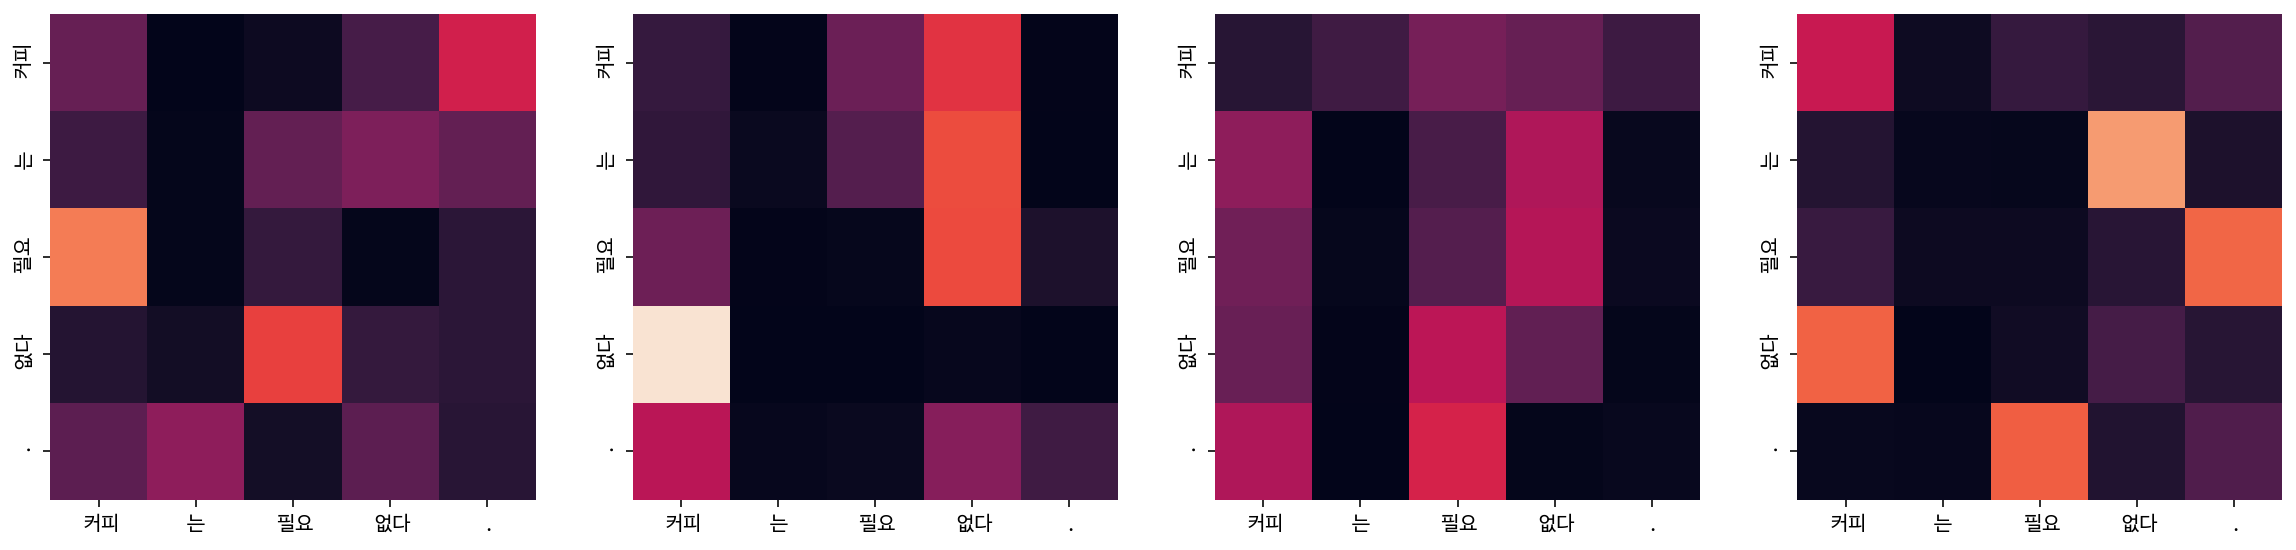

Encoder Layer 2


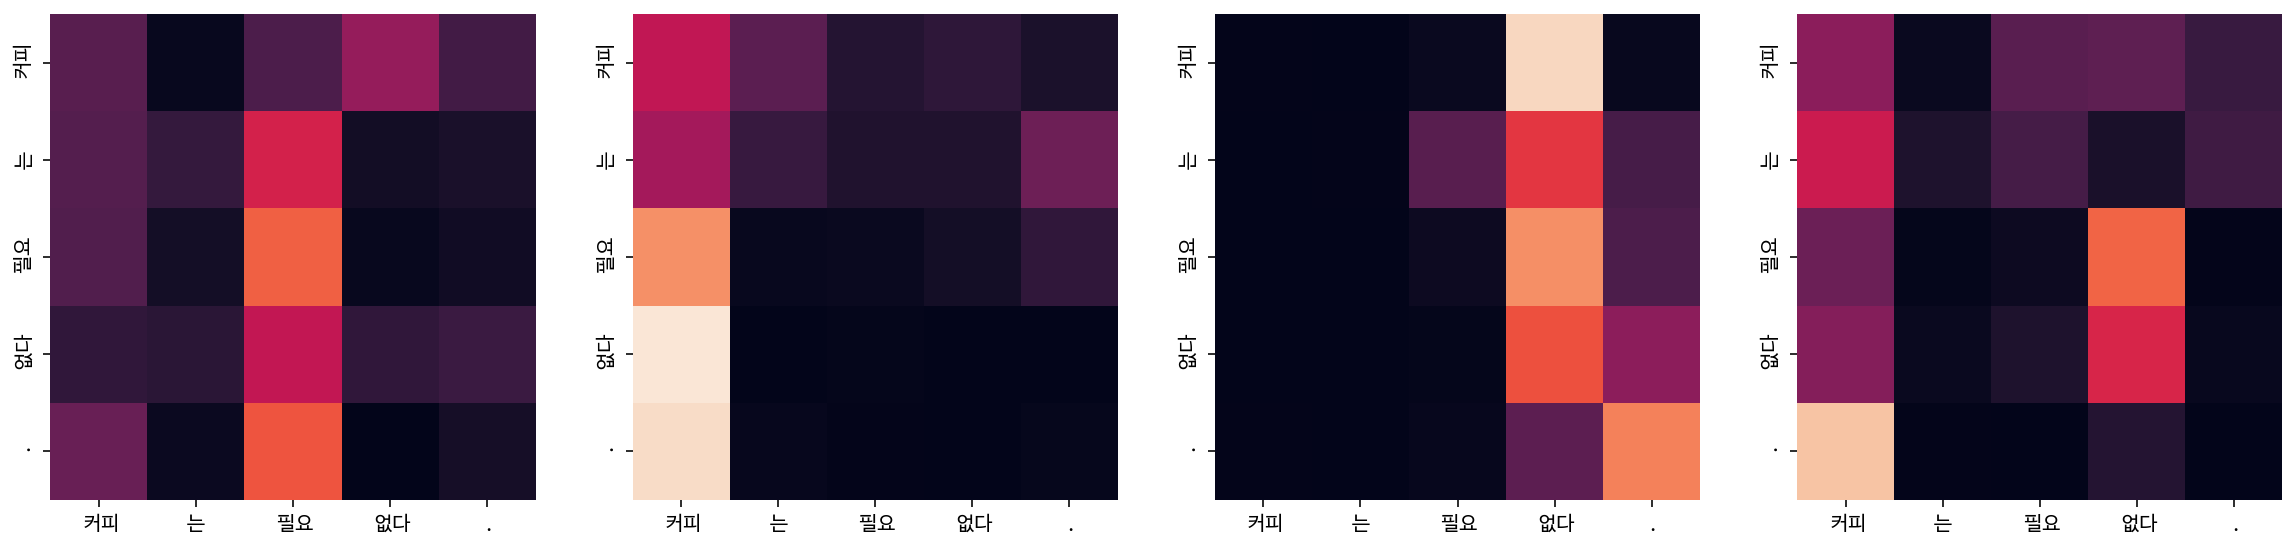

Decoder Self Layer 1


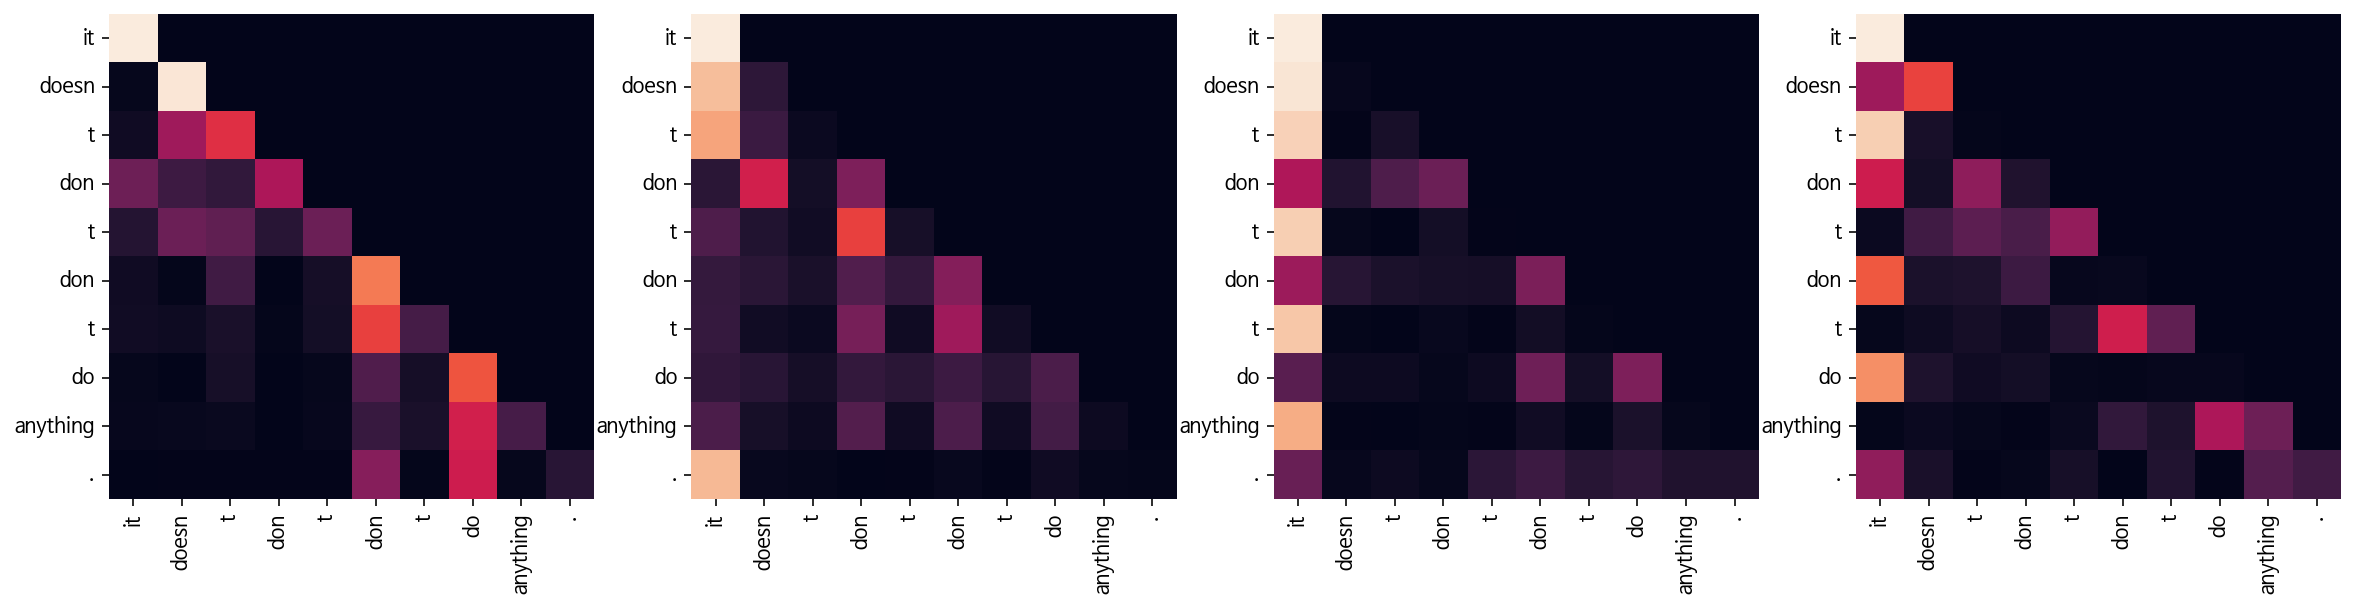

Decoder Src Layer 1


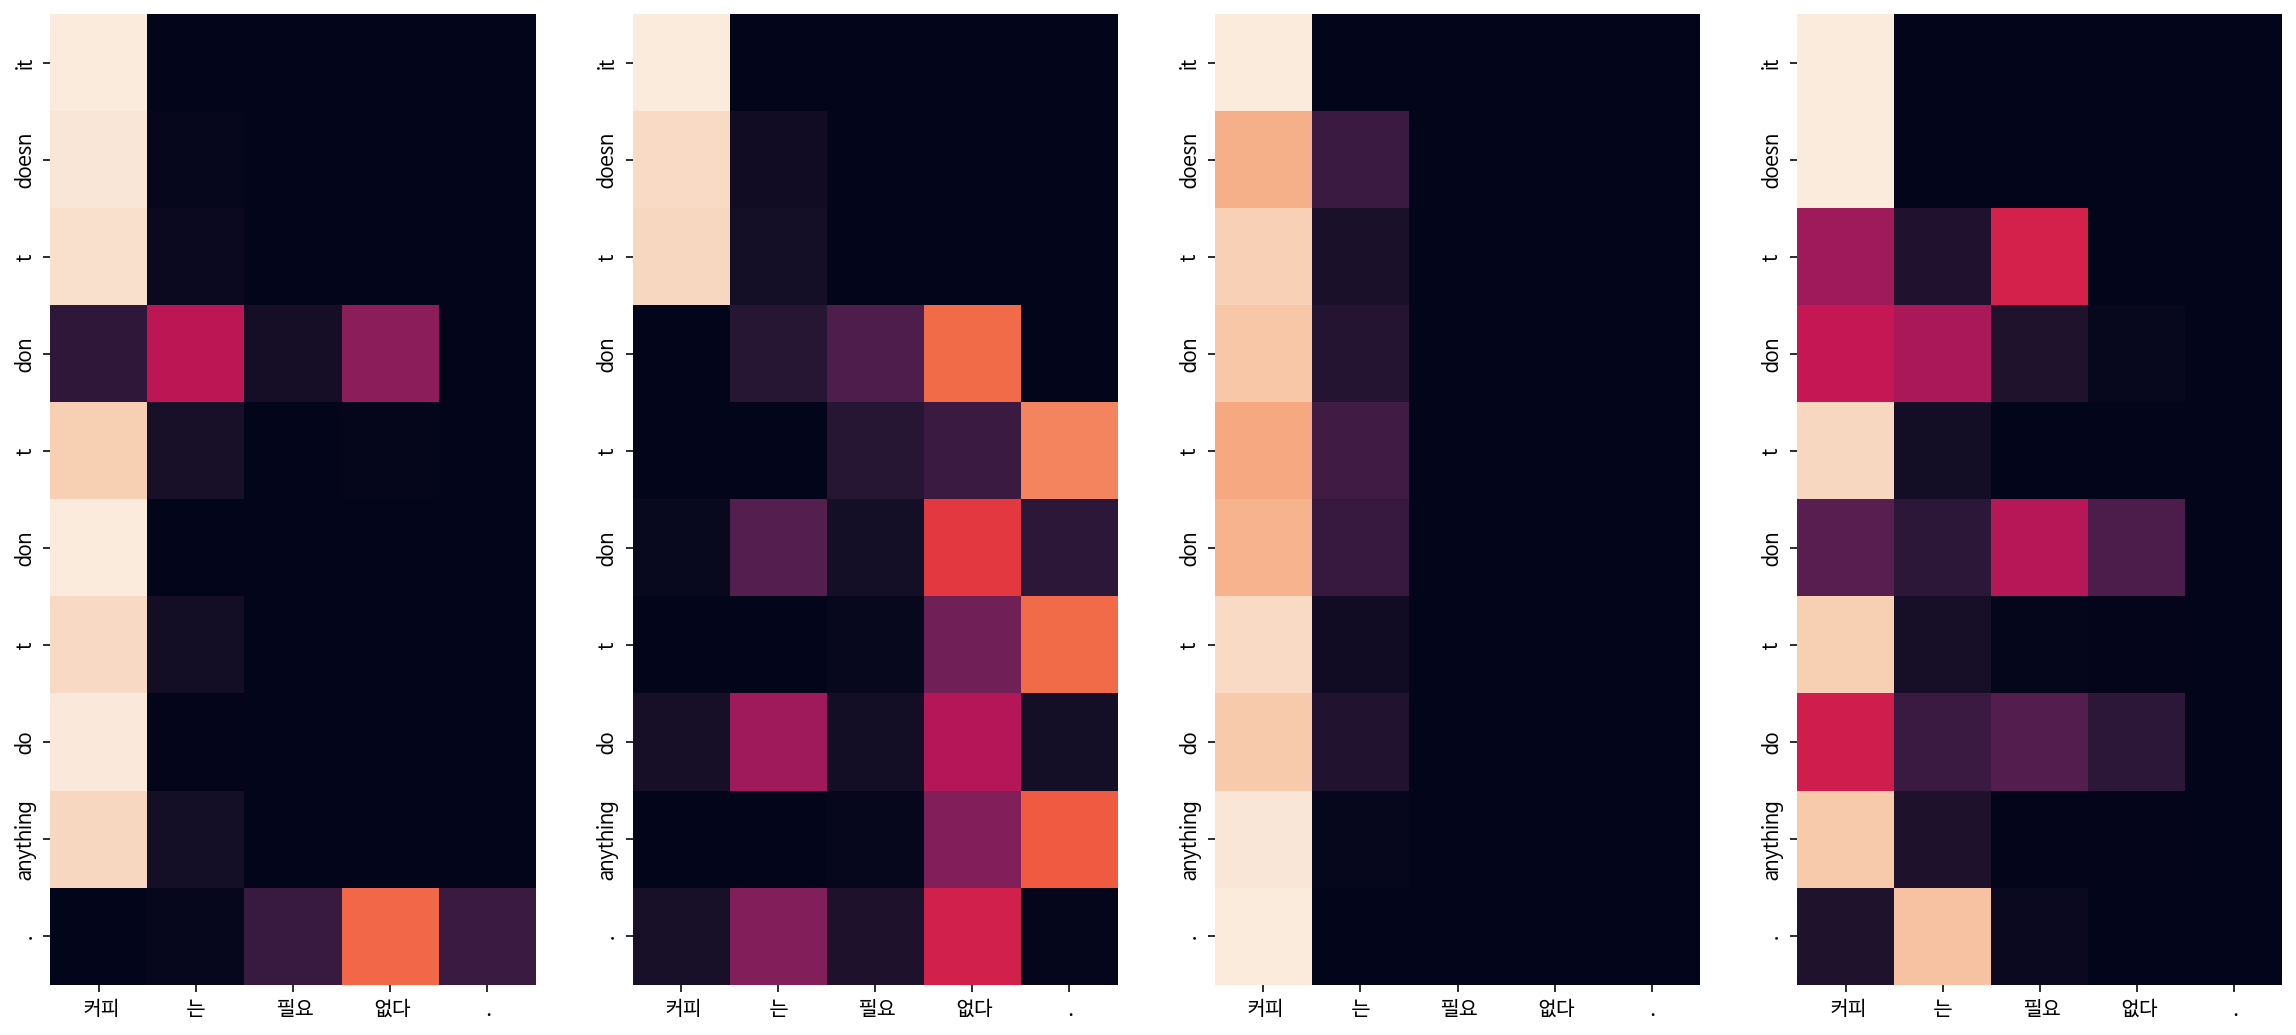

Decoder Self Layer 2


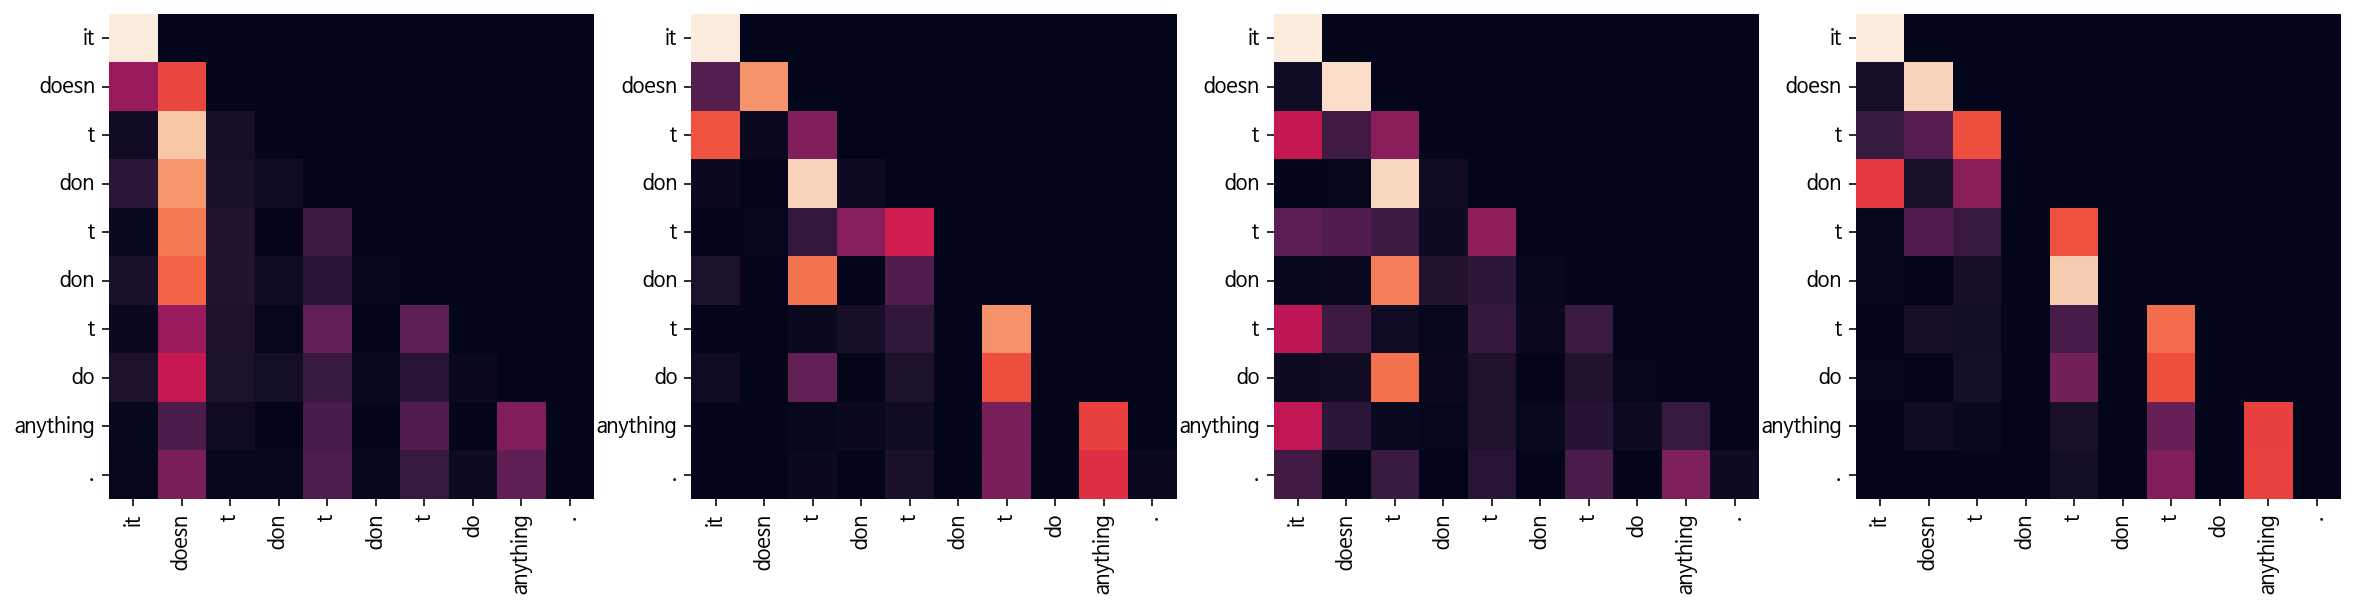

Decoder Src Layer 2


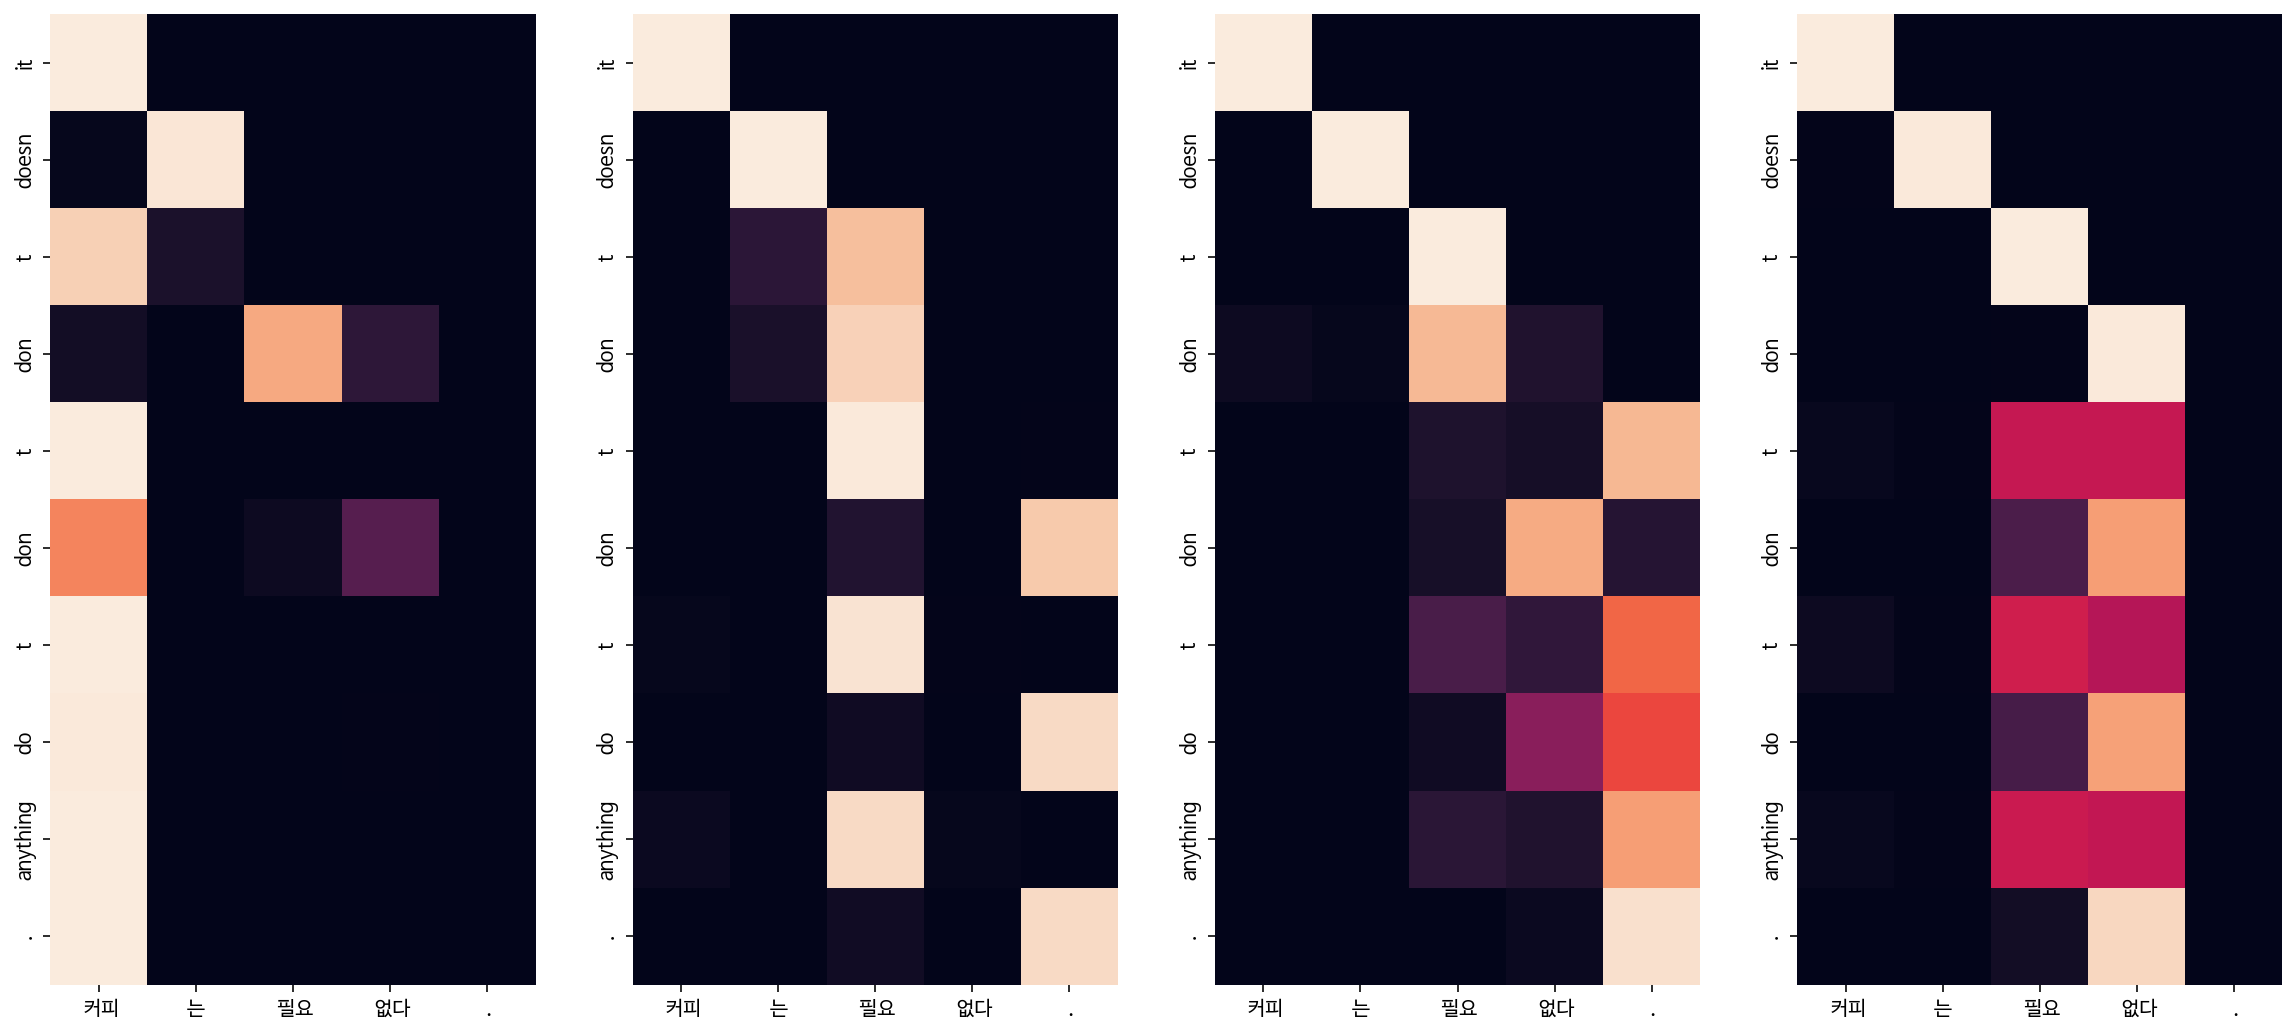

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . a . m . et .
Encoder Layer 1


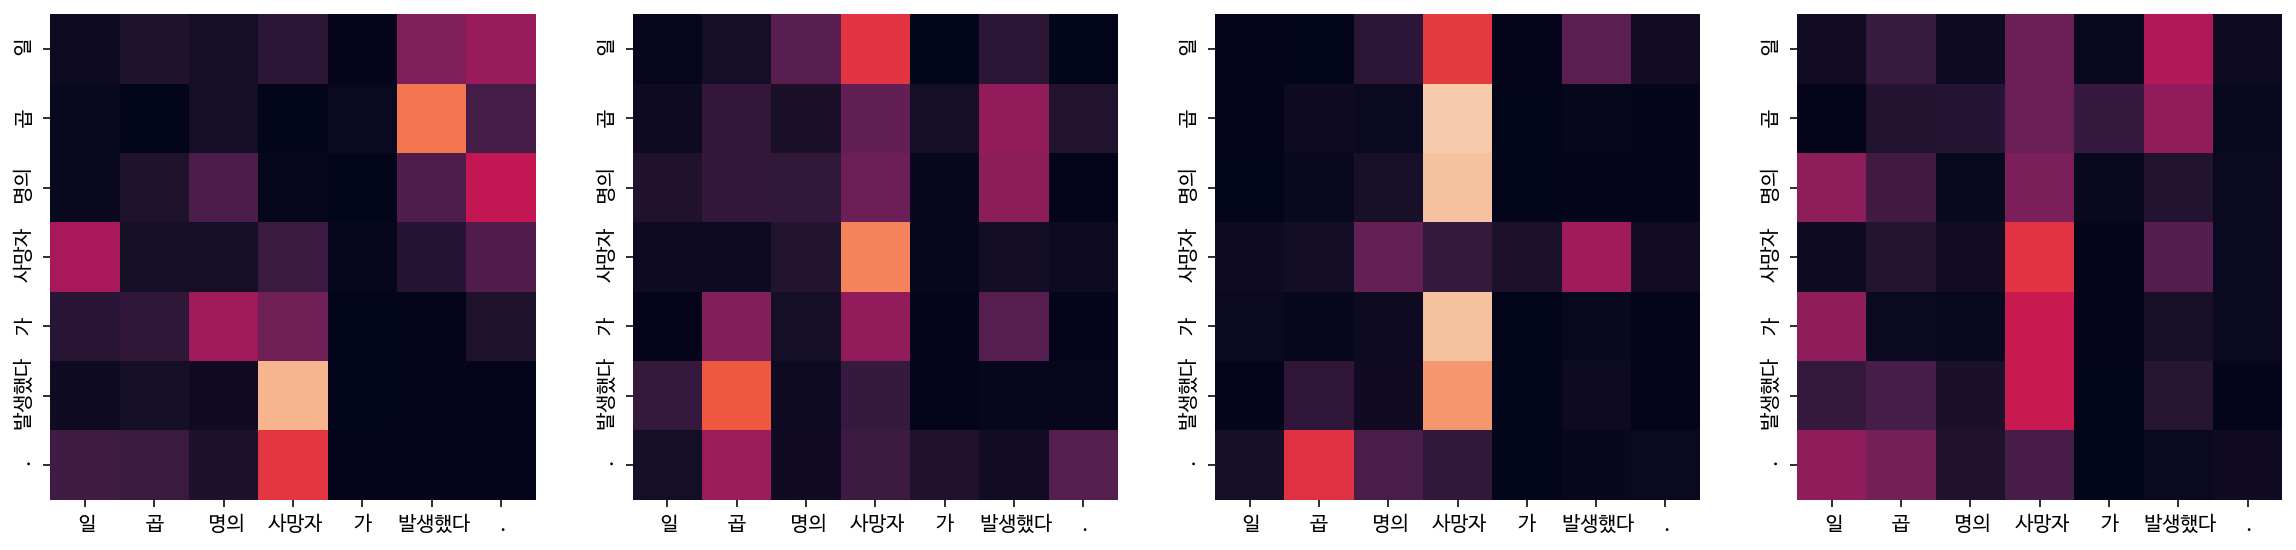

Encoder Layer 2


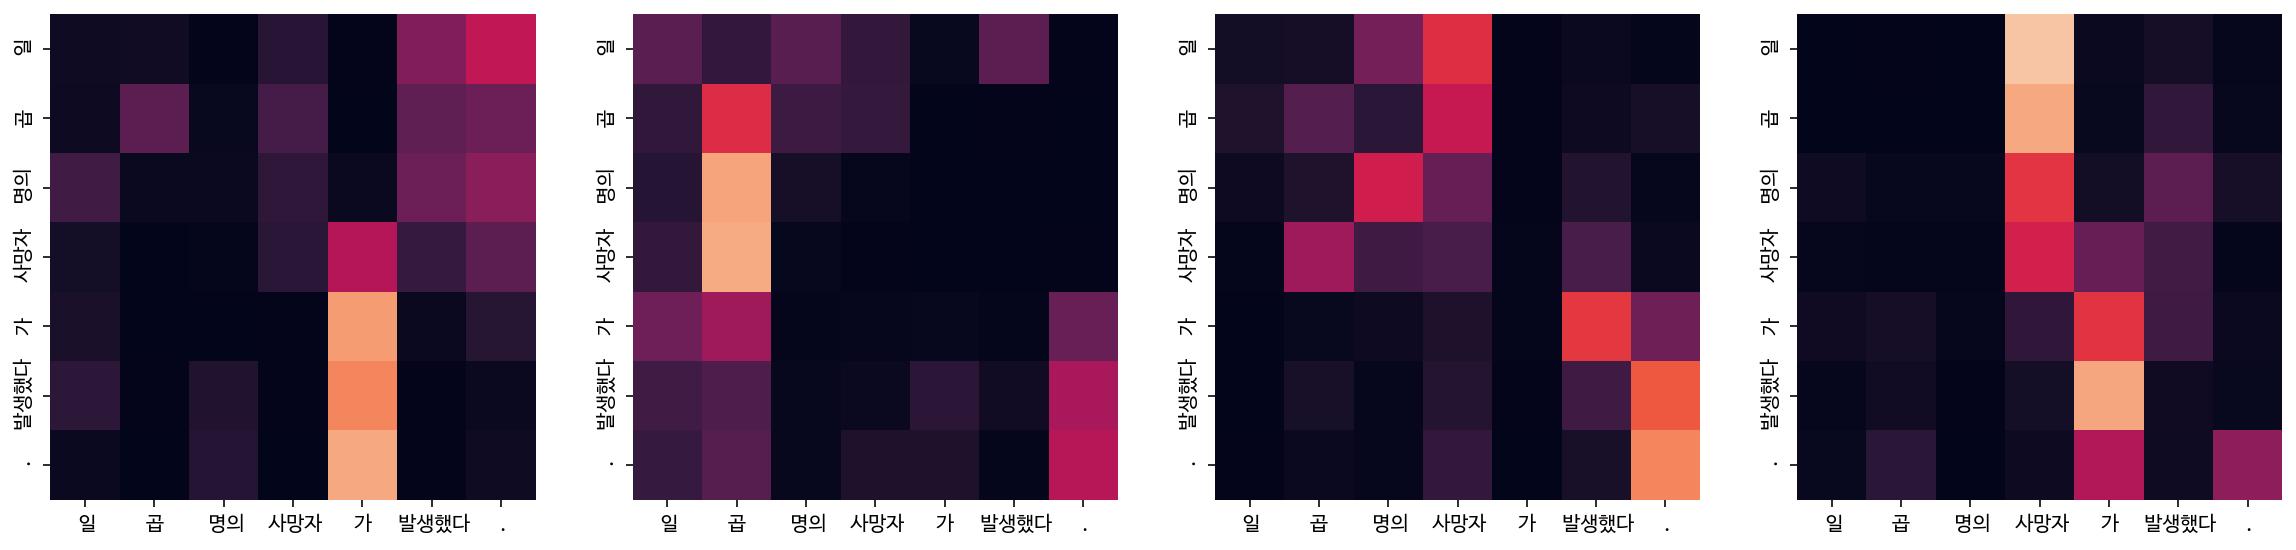

Decoder Self Layer 1


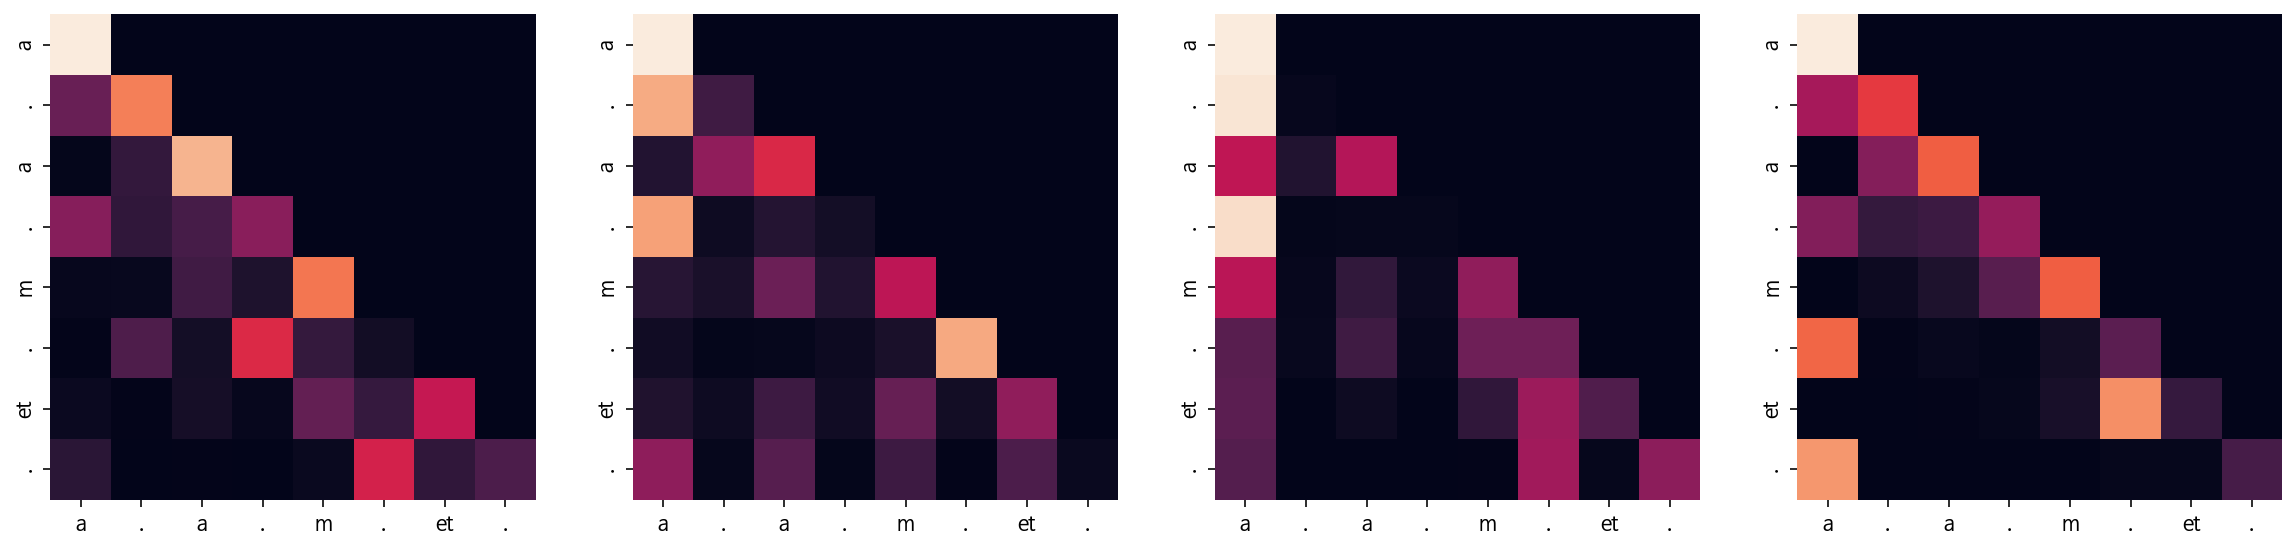

Decoder Src Layer 1


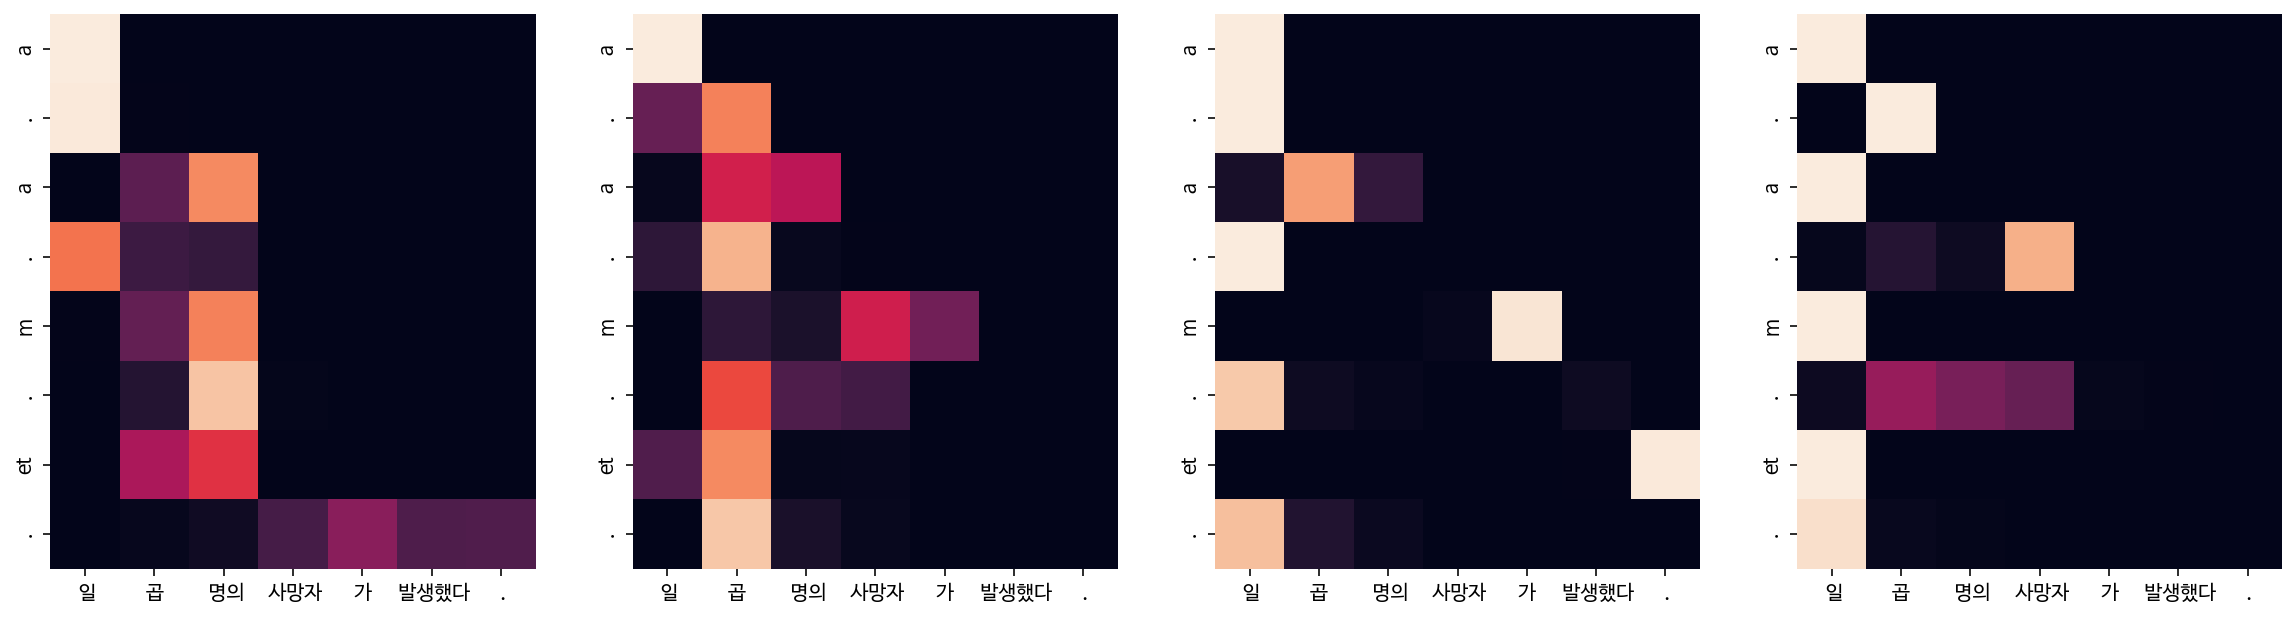

Decoder Self Layer 2


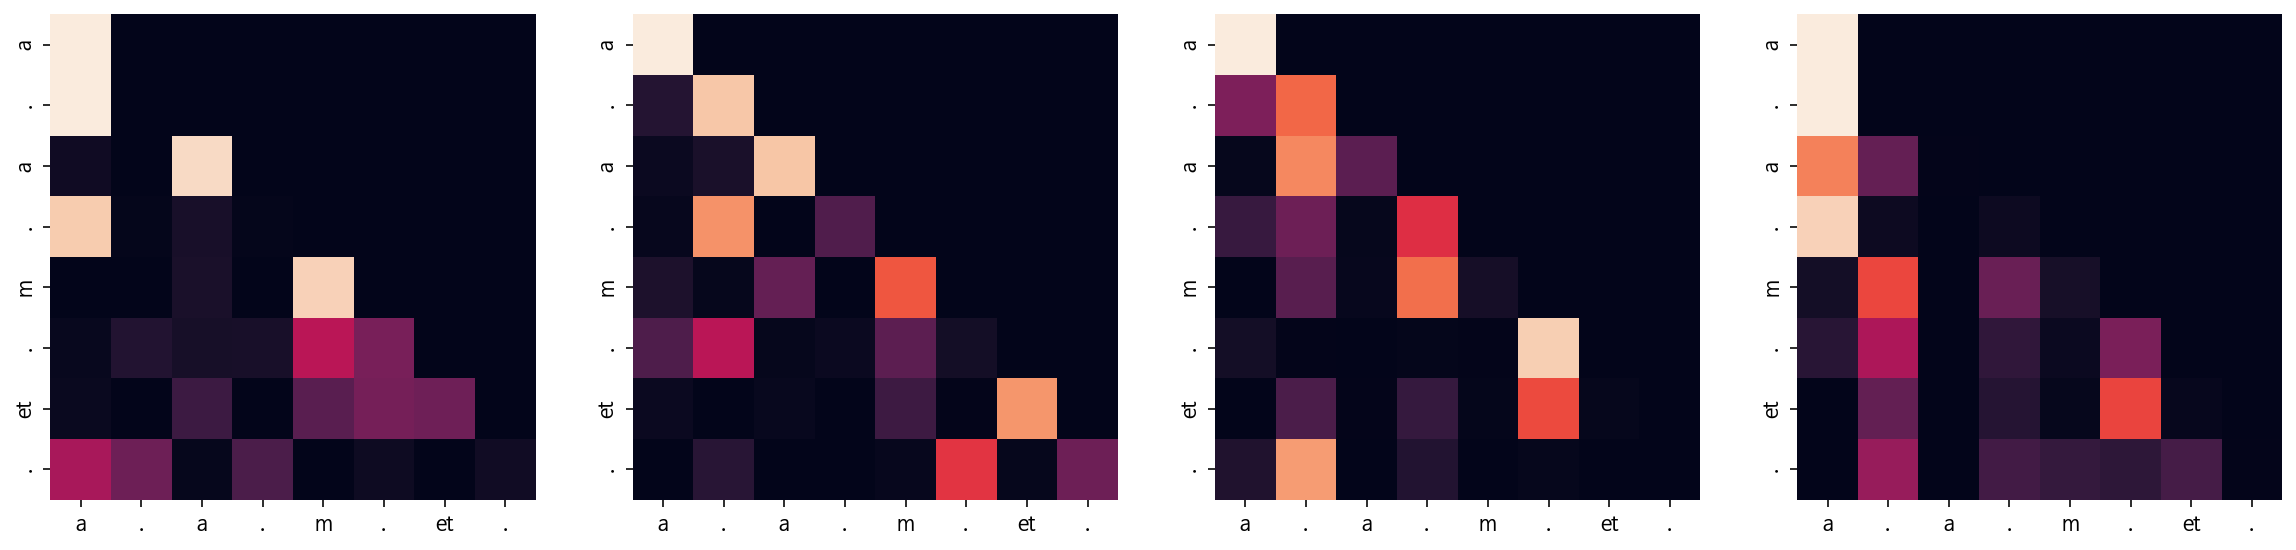

Decoder Src Layer 2


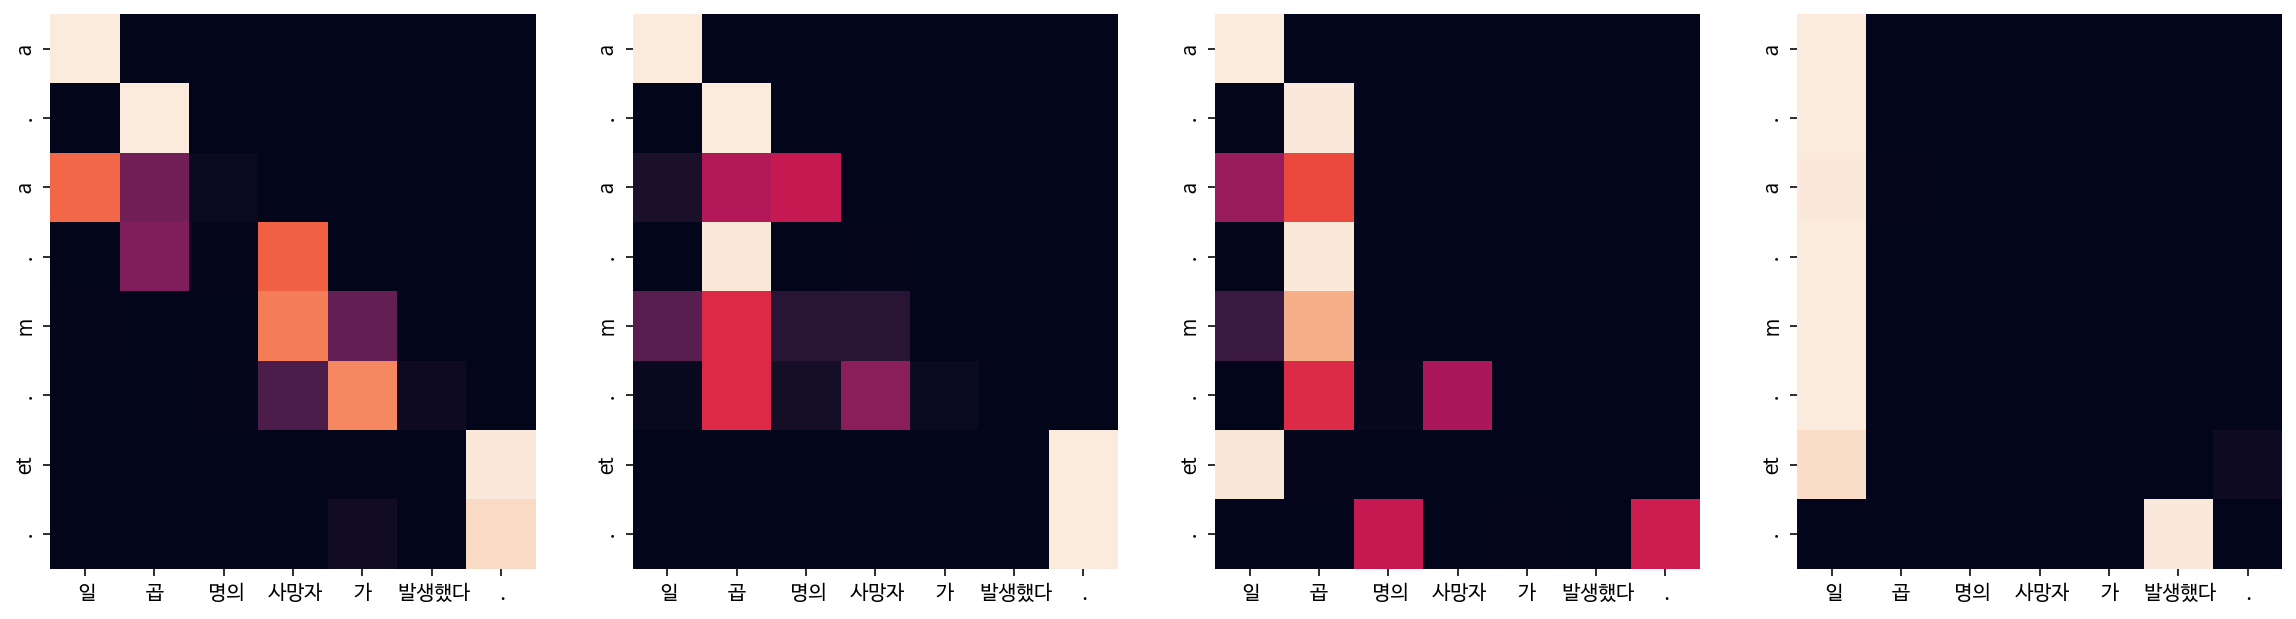

In [41]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

# 회고 
저번에 했던 seq2seq 번역기 보다는 성능이 좋아졌다. 또한 loss도 잘 떨어졌다. 속도 자체도 더 빠르거나 비슷했고 시각화를 통해 어텐션이 어디에 중점을 두고 있는지 볼 수 있었던 프로젝트였다. attention 그래프 에 대해서 좀더 공부를 해보아야겠다.. 편향성 이후로 난이도가 급격하게 증가해서 다음주 방학에 재학습을 해야겠다... 